## CASA007 Quantative Methods

## Assesment 4: Written Investigation 

# The Crime Reducing Effect of Street Lights in Lambeth, London; A Quantitative Exploration

> This notebook contains the code for analysis conducted in the written investigation. The workflow is as follows:


1. Set up notebook
2. Import data
3. Plot data
4. Spatial join
5. Create density of street lights
6. Clean crime data and create crime rates
7. Descriptive stats
8. T Test
9. Multiple Linear Regression
10. Odds Ratio
    


## 1. Setting up Notebook

### 1.1 Packages

In [139]:
# Import packages

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import urllib
import zipfile
import re
import csv
import gzip
import statsmodels.api as sm
import contextily as ctx
import scipy.stats as stats
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from pyproj import Proj, transform

## 1.2 Set up folders

In [2]:
# Look at location of working directory

print("Working directory is " + os.getcwd())

Working directory is /home/jovyan/work/OneDrive/UCL/Quantitative-Methods/Assesment 4


In [3]:
# Create a folder for data to be downloaded into

if os.path.isdir("data") is not True:
    print("Creating 'Data' directory...")
    os.mkdir("data")

In [4]:
# Create a folder to save figures in 

if os.path.isdir("figures") is not True:
    print("Creating 'Data' directory...")
    os.mkdir("figures")

## 1.3 Functions

In [5]:
# To check projections of spatial data frames

def projection(df1, df2):
    if df1.geometry.crs==df2.geometry.crs:
        print("The projections are the same")
    else:
        print("Need to change the projections")
        print("Projection of first data frame is " + str(df1.crs.name))
        print("Projection of second data frame is " + str(df2.crs.name))

In [6]:
# Check if merges havebeen successfull

def success(olddataframe, newdataframe):
    print(f"There are " + str(newdataframe.isnull().sum().sum()) + " NaN values in the data frame")
    print(f"These NaN values are located in columns: " + str(newdataframe.columns[newdataframe.isnull().any()].tolist()))
    if len(olddataframe) == len(newdataframe):
        print("Success! The length's are the same")
    else:
        print("Something is wrong!")
        diff = len(newdataframe)-len(olddataframe)
        print(f"{diff} rows are missing")

In [7]:
# Check info of a df

def infodf(dataframe):
    print(f"There are "+str(len(dataframe)) + " rows in the dataframe")
    print(f"There are " + str(dataframe.shape[1]) + " columns in the data frame")
    print(f"The columns of the dataframe are: " + str(dataframe.columns))
    print(f"There are " + str(dataframe.isnull().sum().sum()) + " NaN values in the data frame")
    print(f"These NaN values are located in columns: " + str(dataframe.columns[dataframe.isnull().any()].tolist()))
    

In [8]:
# To print all columns of a df

def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)

In [137]:
# Calculate odds ratio and print values of exposed and control areas

def oddratio(url, df):
    print(f"Odds Ratio for {url}")
    buffercount = pd.read_csv(url)
    crimes_within = buffercount["NUMPOINTS"].sum()
    total_crimes = len(df)
    crimes_outside = total_crimes-crimes_within
    data = [[crimes_within, total_crimes],[crimes_outside,total_crimes]]
    odds_ratio_df = pd.DataFrame(data, columns = ["Within Buffer", "Outside Buffer"], index=["Observed Crimes", "Total Crimes"])
    oddsratio, pvalue = stats.fisher_exact(odds_ratio_df)
    print("OddsR: ", oddsratio, "p-Value:", pvalue)
    print(crimes_within, crimes_outside)
    print(total_crimes)
    print(crimes_within/total_crimes)
    print(crimes_outside/total_crimes)

In [10]:
# Change point data for lat lon to eating northing to use in British National Grid

v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy",
        towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")


def ENtoLL84(easting, northing):
    """Returns (longitude, latitude) tuple
    """
    vlon36, vlat36 = vgrid(easting, northing, inverse=True)
    return transform(v36, v84, vlon36, vlat36)

def LL84toEN(longitude, latitude):
    """Returns (easting, northing) tuple
    """
    vlon36, vlat36 = transform(v84, v36, longitude, latitude)
    return vgrid(vlon36, vlat36)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [11]:
# Calcualte VIF for regression
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

## 2. Import in data

### 2.1 Crime data

> Sourced from www.data.police.uk/data/
> Force chosen is Metropolitan Police Service, temporally filtered to 01/2019 - 12/2019

> Data stored on github

In [12]:
# Read in dataframes

df1 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-01-metropolitan-street.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-02-metropolitan-street.csv")
df3 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-03-metropolitan-street.csv")
df4 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-04-metropolitan-street.csv")
df5 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-05-metropolitan-street.csv")
df6 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-06-metropolitan-street.csv")
df7 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-07-metropolitan-street.csv")
df8 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-08-metropolitan-street.csv")
df9 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-09-metropolitan-street.csv")
df10 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-10-metropolitan-street.csv")
df11 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-11-metropolitan-street.csv")
df12 = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/Crime%20Data/2019-12-metropolitan-street.csv")

In [13]:
# Merge all the dataframes

crime_winter = pd.concat([df1, df2, df12])
crime_spring = pd.concat([df3,df4,df5])
crime_summer = pd.concat([df6,df7,df8])
crime_aut = pd.concat([df9,df10,df11])

crime_total = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12])

## 2.2 Street Light Data

In [14]:
# Read in street light data

lights = gpd.read_file("https://opendata.arcgis.com/datasets/a2bba64be53d4201ae00ceb3031a396c_0.geojson")

## 2.3 Shapefiles

### 2.3.1 LSOA and Borough 

In [15]:
# Import shapefile data for London - LSOA's and Boroughs

# Read in from URL and unzip file
url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"

# The path to save data
path = os.path.join("data", "statistical-gis-boundaries-london.zip")

# Retriving the data
r    = urllib.request.urlretrieve(url, path)

# Unzipping the zipfile
z    = zipfile.ZipFile(path)

# Extracting the folders into the data folder
m    = z.extractall("data")

In [16]:
# Read in LSOA shapefile

lsoa = gpd.read_file(os.path.join("data","statistical-gis-boundaries-london","ESRI","LSOA_2011_London_gen_MHW.shp"))

In [17]:
# Read in Borough data

bor = gpd.read_file(os.path.join("data","statistical-gis-boundaries-london","ESRI","London_Borough_Excluding_MHW.shp"))

In [18]:
# Filter

lambeth_lsoa = lsoa.loc[lsoa["LAD11NM"]=="Lambeth"]

lambeth_outline = bor.loc[bor["NAME"]=="Lambeth"]

### 2.3.2 Greenspaces

> Included for later analysis, as speculated that there will not be as many street lights in a park, altering crime patterns.

In [19]:
# Parks shapefile

parks = gpd.read_file("https://opendata.arcgis.com/datasets/e9c2ebab1d0e4bbb9b7c418512ae1a4f_0.geojson")

In [20]:
# Check projections
# Change projection 

projection(lambeth_lsoa, lambeth_outline)

The projections are the same


In [21]:
# Check projections

projection(lambeth_lsoa, lights)

Need to change the projections
Projection of first data frame is OSGB 1936 / British National Grid
Projection of second data frame is WGS 84


In [22]:
# Change projection

lights = lights.to_crs(lambeth_lsoa.crs.to_string())

In [23]:
# Check projection 

projection(lambeth_lsoa, parks)

Need to change the projections
Projection of first data frame is OSGB 1936 / British National Grid
Projection of second data frame is WGS 84


In [24]:
# Change projection

parks = parks.to_crs(lambeth_lsoa.crs.to_string())

In [25]:
# Clip parks to only within Lambeth

parks = gpd.clip(parks, lambeth_outline)

In [26]:
# Clip lights

lights = gpd.clip(lights, lambeth_outline)

In [27]:
projection(parks, lights)

The projections are the same


## 2.3.3 LSOA Data

> Metadata can be found at https://github.com/kingsgeocomp/geocomputation/blob/master/data/LSOA_metadata.xlsx

In [28]:
# Read in LSOA data

cols=['LSOA11CD', 'GreenspaceArea', 'RoadsArea',
       'Owned', 'SharedOwnshp', 'SocialRented', 'PrivateRented', 'RentFree',
       'ORroomsM1', 'ORbedsM1', 'RoomsHH', 'BedsHH', 'White', 'MultiEthnic',
       'Asian', 'Black', 'OtherEthnic', 'MedianIncome','Area']

lsoa_data = pd.read_csv('https://github.com/kingsgeocomp/geocomputation/blob/master/data/LSOA%20Data.csv.gz?raw=true',compression='gzip',low_memory=False, usecols=cols)

In [29]:
# Merge with LSOA shapefile, using left join to only get lambeth LSOA's

lambeth_lsoa = pd.merge(lambeth_lsoa, lsoa_data, how="left", on="LSOA11CD")

In [30]:
# Look at descriptive stats

lambeth_lsoa.describe()

USUALRES     HHOLDRES   COMESTRES      POPDEN       HHOLDS  \
count   178.000000   178.000000  178.000000  178.000000   178.000000   
mean   1702.730337  1685.960674   16.769663  131.436517   730.432584   
std     237.184701   240.503388   43.505020   49.546563   126.519905   
min    1043.000000  1026.000000    0.000000   31.100000   453.000000   
25%    1537.500000  1531.250000    0.000000   99.375000   654.250000   
50%    1665.500000  1651.500000    2.000000  122.800000   723.000000   
75%    1821.750000  1815.750000   15.000000  162.750000   789.000000   
max    2455.000000  2446.000000  389.000000  344.600000  1096.000000   

        AVHHOLDSZ  GreenspaceArea      RoadsArea       Owned  SharedOwnshp  \
count  178.000000      178.000000     178.000000  178.000000    178.000000   
mean     2.329775    12417.165497   61019.439591  240.926966     11.162921   
std      0.207108    50368.863088   79062.644219  101.355671     17.863936   
min      1.700000        0.000000       0.000000   36.000000      0.000000   
25%      2.200000        0.000000       0.000000  151.500000      2.000000   
50%      2.300000        0.000000   35872.343209  240.500000      5.500000   
75%      2.400000     3568.479839   99668.418850  320.750000     13.000000   
max      3.000000   519568.170584  591595.557728  535.000000    162.000000   

       ...    ORbedsM1     RoomsHH      BedsHH        White  MultiEthnic  \
count  ...  178.000000  178.000000  178.000000   178.000000    178.00000   
mean   ...   96.668539    4.340449    2.302809   972.050562    130.11236   
std    ...   32.570605    0.512933    0.305029   275.876278     35.98915   
min    ...   19.000000    3.400000    1.700000   293.000000     47.00000   
25%    ...   72.250000    4.000000    2.100000   776.500000    108.00000   
50%    ...  100.000000    4.200000    2.250000   977.000000    128.50000   
75%    ...  119.000000    4.500000    2.400000  1145.000000    148.75000   
max    ...  176.000000    6.500000    3.600000  1659.000000    254.00000   

            Asian        Black  OtherEthnic  MedianIncome           Area  
count  178.000000   178.000000   178.000000    178.000000     178.000000  
mean   117.629213   441.247191    41.691011  37926.011236  150636.543150  
std     69.751355   209.506754    20.313643   5351.645857   76731.799557  
min     32.000000    46.000000     3.000000  27760.000000   53149.510759  
25%     75.250000   299.000000    27.250000  33697.500000  106075.700569  
50%    100.000000   415.000000    38.500000  38305.000000  135478.306742  
75%    135.750000   553.750000    51.750000  41070.000000  169575.494800  
max    580.000000  1063.000000   119.000000  57030.000000  710237.649001  

[8 rows x 24 columns]

## 2.3.4 Deprivation data

In [31]:
# Read in dep data

cols = ["LSOA code (2011)", "Index of Multiple Deprivation (IMD) Score","Crime Score","Crime Decile (where 1 is most deprived 10% of LSOAs)"]
imd = pd.read_csv("https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/845345/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv", usecols=cols)

In [32]:
# Filter so only get scores

imd_score = imd.rename(columns={"LSOA code (2011)":"Codes"})

In [33]:
# read in other deprivation data 

dem_census = pd.read_csv("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/LSOAData/Census.csv")

In [34]:
# Merge

dem = pd.merge(imd_score, dem_census, on="Codes")

In [35]:
# Filter to lambeth

lambeth_dem = dem[dem["Names"].str.contains("Lambeth")]

In [36]:
# Change to not speaking english 

lambeth_dem["English not first language (%)"] = 100-lambeth_dem["English as first language (%)"]

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


# 3. Plots

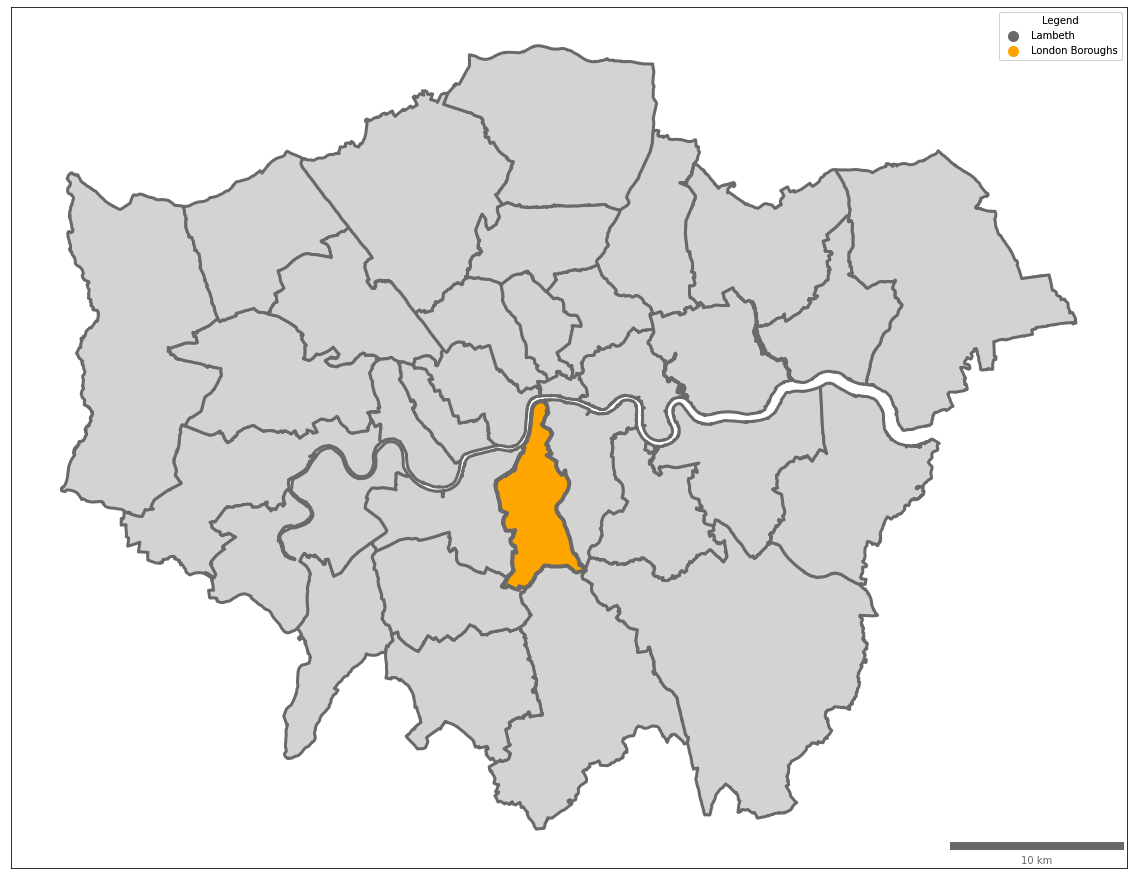

In [37]:
# Plot shapfiles

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lambeth_outline.plot(ax=ax, edgecolor="dimgray", facecolor="orange", zorder=10, linewidth=4)

# Plot inner london boundary
bor.plot(ax=ax, edgecolor="dimgray", facecolor="lightgrey", linewidth=3)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow
#ax.text(x=532700, y=169100,s='N', fontsize=30, color="dimgray")
#ax.arrow(532600, 169110, 0,200,length_includes_head=True, head_width=100, head_length=100, overhang=2, zorder=1, color="dimgray")
    
# Add legend

l1 = plt.scatter([],[], s=100, marker='o', color='dimgray')
l2 = plt.scatter([],[], s=100, marker='o', color='orange')
  
labels = ["Lambeth", "London Boroughs"]

legend = ax.legend([l1, l2], labels, loc="upper right", title='Legend')
    
ax.add_artist(legend)

plt.savefig(os.path.join("figures","LambethinLondon.png"), transparent=True)

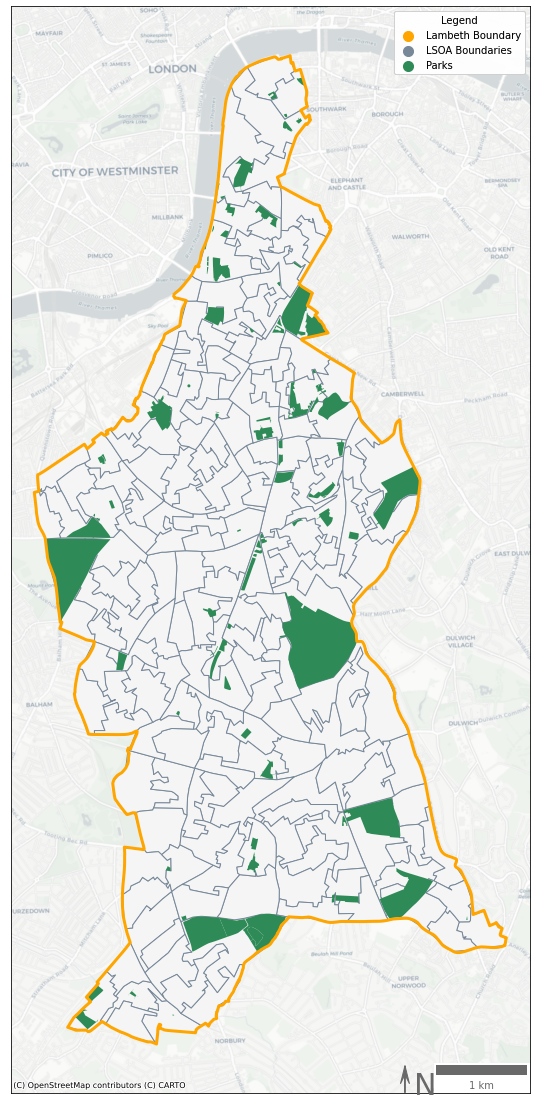

In [38]:
# Plot shapfiles

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
#ax.set_aspect('equal')
#ax.axis('off')
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lambeth_lsoa.plot(ax=ax, edgecolor="lightslategray", facecolor="whitesmoke")

# Plot inner london boundary
lambeth_outline.plot(ax=ax, edgecolor="orange", facecolor="none", linewidth=3, zorder=10)

# Plot parks
parks.plot(ax=ax, facecolor="seagreen")

# Add basemap
ctx.add_basemap(ax, crs=lsoa.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow
ax.text(x=532700, y=169100,s='N', fontsize=30, color="dimgray")
ax.arrow(532600, 169110, 0,200,length_includes_head=True, head_width=100, head_length=100, overhang=2, zorder=1, color="dimgray")
    
# Add legend

l1 = plt.scatter([],[], s=100, marker='o', color='orange')
l2 = plt.scatter([],[], s=100, marker='o', color='lightslategray')
l3 = plt.scatter([],[], s=100, marker='o', color='seagreen')
  
labels = ["Lambeth Boundary", "LSOA Boundaries", "Parks"]

legend = ax.legend([l1, l2, l3], labels, loc="upper right", title='Legend')
    
ax.add_artist(legend)

# Save figure

plt.savefig(os.path.join("figures","Lambeth_Shape_and_Parks.png"), dpi=300, bbox_inches="tight",transparent=True)

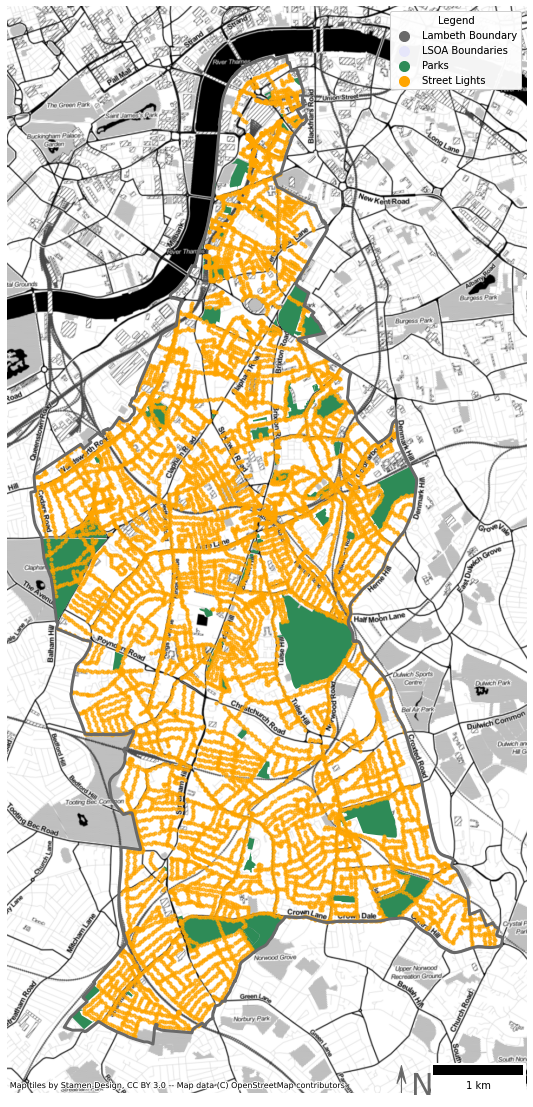

In [39]:
# Plot street lights

# Plot street lights

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.axis('off')

# Plot outlines of LSOA'S 
#lambeth_lsoa.plot(ax=ax, edgecolor="lightslategray", facecolor="lavender")

# Plot inner london boundary
lambeth_outline.plot(ax=ax, edgecolor="dimgray", facecolor="none", linewidth=3, zorder=10)

# Plot parks
parks.plot(ax=ax, facecolor="seagreen")

# Add basemap
ctx.add_basemap(ax, crs=lsoa.crs.to_string(), source=ctx.providers.Stamen.Toner)

# Plot streetlights
lights.plot(ax=ax, facecolor="orange",markersize=10, alpha=0.7, edgecolor="orange")

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, location="lower right")) 

# Add north arrow
ax.text(x=532700, y=169100,s='N', fontsize=30, color="dimgray")
ax.arrow(532600, 169110, 0,200,length_includes_head=True, head_width=100, head_length=100, overhang=2, zorder=1, color="dimgray")
    
# Add legend

l1 = plt.scatter([],[], s=100, marker='o', color='dimgray')
l2 = plt.scatter([],[], s=100, marker='o', color='lavender')
l3 = plt.scatter([],[], s=100, marker='o', color='seagreen')
l4 = plt.scatter([],[], s=100, marker='o', color='orange', edgecolor="orange")
  
labels = ["Lambeth Boundary", "LSOA Boundaries", "Parks","Street Lights"]

legend = ax.legend([l1, l2, l3,l4], labels, loc="upper right", title='Legend')
    
ax.add_artist(legend)

# Save figure

plt.savefig(os.path.join("figures","Lambeth_Lights.png"), transparent=True)

## 4. Spatially Join Lights and LSOA's

In [40]:
# Spatial join 

lights = lights.reset_index()

lights_df = gpd.sjoin(lambeth_lsoa, lights, how="left")

In [41]:
success(lights_df, lights)

There are 12643 NaN values in the data frame
These NaN values are located in columns: ['USRN', 'LOCALITY', 'LOCATION', 'HEIGHT']
Something is wrong!
38 rows are missing


## 5. Create density of lights

In [42]:
# Group 

# Create count
count = lights_df["LSOA11CD"].groupby(lights_df["LSOA11CD"]).count()

# Create df from count
countdf = pd.DataFrame(count)

# Rename column for merge
countdf = countdf.rename(columns={"LSOA11CD":"lightcount"})

# Reset column for merge
countdf = countdf.reset_index()

In [43]:
countdf['lightcount'] = countdf['lightcount'].fillna(0)

In [44]:
# Merge with main LSOA dataframe

lambeth_lsoa = lambeth_lsoa.merge(countdf, how="left", on="LSOA11CD", suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [45]:
# Calculate density

lambeth_lsoa["light_density"] = lambeth_lsoa["lightcount"]/lambeth_lsoa["Area"]
lambeth_lsoa = lambeth_lsoa.replace([np.inf, -np.inf], 0)

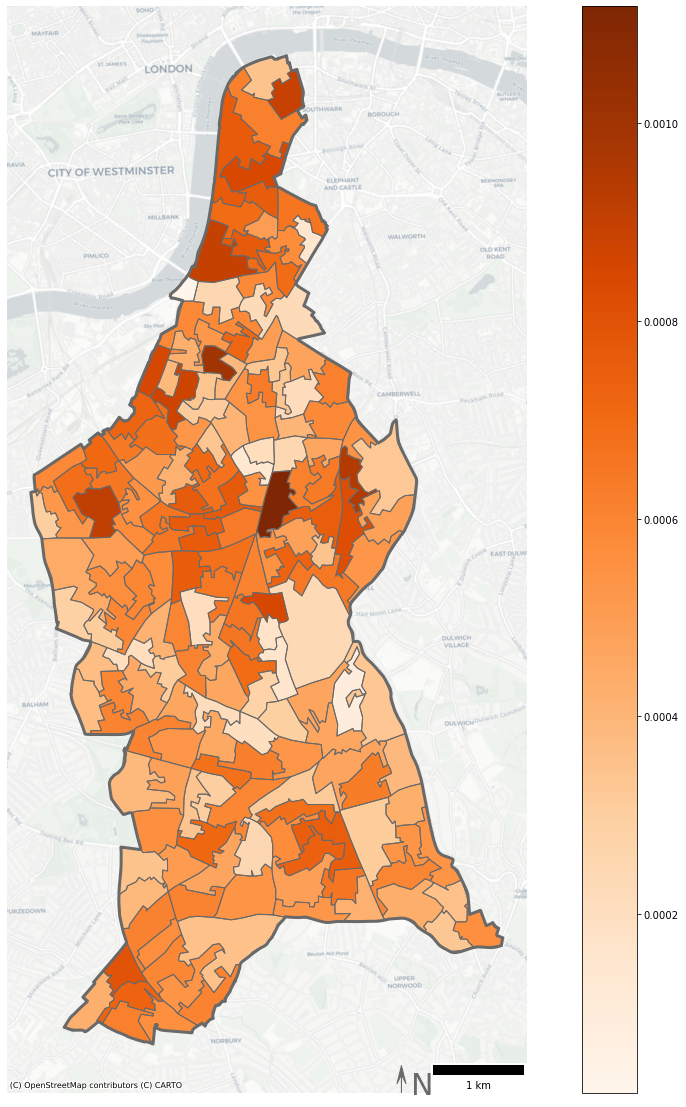

In [46]:
# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.axis('off')

# Plot outlines of LSOA'S 
lambeth_lsoa.plot(ax=ax, edgecolor="dimgray", facecolor="none", zorder=12)

# Plot inner london boundary
lambeth_outline.plot(ax=ax, edgecolor="dimgray", facecolor="none", linewidth=3, zorder=10)

# Plot parks
#parks.plot(ax=ax, facecolor="seagreen", alpha=0.7)

# Plot streetlights
lambeth_lsoa.plot(ax=ax, column="light_density", legend=True, cmap="Oranges")

# Add basemap
ctx.add_basemap(ax, crs=lsoa.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, location="lower right")) 

# Add north arrow
ax.text(x=532700, y=169100,s='N', fontsize=30, color="dimgray")
ax.arrow(532600, 169110, 0,200,length_includes_head=True, head_width=100, head_length=100, overhang=2, zorder=1, color="dimgray")
    
# Save figure

plt.savefig(os.path.join("figures","DensityofLights.png"), transparent=True)

No handles with labels found to put in legend.


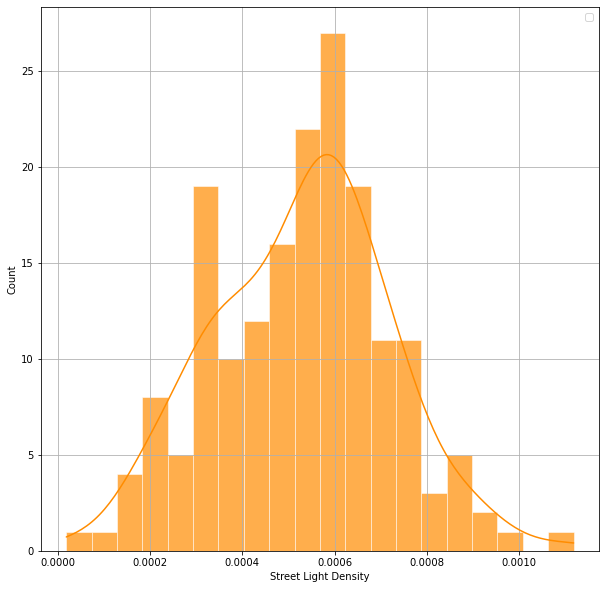

In [47]:
# Plot distribution 

fig, axs = plt.subplots(1, figsize=(10,10))
sns.set(style="whitegrid")

sns.histplot(data=lambeth_lsoa, x="light_density", kde=True, color="darkorange", linewidth=0.5, alpha=0.7, bins=20)

axs.set_xlabel("Street Light Density")
axs.set_ylabel("Count")

axs.grid()
plt.legend() 
plt.show()
fig.savefig(os.path.join("figures","lightdist"), transparent=True)

## 6. Clean Crime Data

In [48]:
infodf(crime_total)

There are 1108042 rows in the dataframe
There are 12 columns in the data frame
The columns of the dataframe are: Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context'],
      dtype='object')
There are 1640416 NaN values in the data frame
These NaN values are located in columns: ['Crime ID', 'Longitude', 'Latitude', 'LSOA code', 'LSOA name', 'Last outcome category', 'Context']


In [49]:
# Find out how many crimes cannot be plotted
# Drop na values

crime_located = crime_total[crime_total['LSOA name'].notna()]

In [50]:
# Filter to lambeth

lambeth_crime = crime_located[crime_located["LSOA name"].str.contains("Lambeth")]

In [51]:
# Filter to street crimes

street_crimes = ["Anti-social behaviour","Public order","Theft from the person","Violence and sexual offences","Robbery"]
lambeth_street_crime = lambeth_crime.loc[lambeth_crime["Crime type"].isin(street_crimes)]

In [52]:
# Make crimes df and geodataframe

lambeth_crime_gdf = gpd.GeoDataFrame(lambeth_street_crime, geometry=gpd.points_from_xy(lambeth_street_crime.Latitude, lambeth_street_crime.Longitude))
lambeth_crime_gdf = lambeth_crime_gdf.set_crs(lambeth_lsoa.crs.to_string())
lambeth_crime_gdf = lambeth_crime_gdf.rename(columns={"LSOA code":"LSOA11CD"})


In [53]:
# Filter dates

street_crimes = ["Anti-social behaviour","Public order","Theft from the person","Violence and sexual offences","Robbery"]
lambeth_street_crime = lambeth_crime.loc[lambeth_crime["Crime type"].isin(street_crimes)]

winter = ["2019-01","2019-02","2019-12"]
crime_winter = lambeth_crime_gdf.loc[lambeth_crime_gdf["Month"].isin(winter)]

summer = ["2019-06","2019-07","2019-08"] 
crime_summer = lambeth_crime_gdf.loc[lambeth_crime_gdf["Month"].isin(summer)]

In [54]:
# Group by to get count of crime type per LSOA 

lambeth_crime_gdf_grouped = lambeth_crime_gdf.groupby(["Crime type","LSOA11CD"], as_index=False).count().drop(['Crime ID','Month','LSOA name','geometry','Falls within', 'Longitude',
       'Latitude', 'Location', 'Last outcome category', 'Context' ], axis=1).rename(columns={"Reported by" :"count"})
lambeth_crime_gdf_grouped_winter = crime_winter.groupby(["Crime type","LSOA11CD"], as_index=False).count().drop(['Crime ID','Month','LSOA name','geometry','Falls within', 'Longitude',
       'Latitude', 'Location', 'Last outcome category', 'Context' ], axis=1).rename(columns={"Reported by" :"count"})
lambeth_crime_gdf_grouped_summer = crime_summer.groupby(["Crime type","LSOA11CD"], as_index=False).count().drop(['Crime ID','Month','LSOA name','geometry','Falls within', 'Longitude',
       'Latitude', 'Location', 'Last outcome category', 'Context' ], axis=1).rename(columns={"Reported by" :"count"})


In [55]:
# Counts of crimes

lambeth_crime_ASB = lambeth_crime_gdf_grouped.loc[lambeth_crime_gdf_grouped["Crime type"].isin(["Anti-social behaviour"])]
lambeth_crime_ASB = lambeth_crime_ASB.drop(["Crime type"], axis=1)
lambeth_crime_ASB = lambeth_crime_ASB.rename(columns={"count":"ASB_Count"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_ASB, on="LSOA11CD", how="left")

lambeth_crime_pub = lambeth_crime_gdf_grouped.loc[lambeth_crime_gdf_grouped["Crime type"].isin(["Public order"])]
lambeth_crime_pub = lambeth_crime_pub.drop(["Crime type"], axis=1)
lambeth_crime_pub = lambeth_crime_pub.rename(columns={"count":"Public_Order_Count"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_pub, on="LSOA11CD", how="left")

lambeth_crime_rob = lambeth_crime_gdf_grouped.loc[lambeth_crime_gdf_grouped["Crime type"].isin(["Robbery"])]
lambeth_crime_rob = lambeth_crime_rob.drop(["Crime type"], axis=1)
lambeth_crime_rob = lambeth_crime_rob.rename(columns={"count":"Robbery_Count"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_rob, on="LSOA11CD", how="left")

lambeth_crime_theft = lambeth_crime_gdf_grouped.loc[lambeth_crime_gdf_grouped["Crime type"].isin(["Theft from the person"])]
lambeth_crime_theft = lambeth_crime_theft.drop(["Crime type"], axis=1)
lambeth_crime_theft = lambeth_crime_theft.rename(columns={"count":"Theft_From_Persons_Count"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_theft, on="LSOA11CD", how="left")

lambeth_crime_vio = lambeth_crime_gdf_grouped.loc[lambeth_crime_gdf_grouped["Crime type"].isin(["Violence and sexual offences"])]
lambeth_crime_vio = lambeth_crime_vio.drop(["Crime type"], axis=1)
lambeth_crime_vio = lambeth_crime_vio.rename(columns={"count":"Violence_Count"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_vio, on="LSOA11CD", how="left")


In [56]:
# Count of crimes in winter

lambeth_crime_ASB = lambeth_crime_gdf_grouped_winter.loc[lambeth_crime_gdf_grouped_winter["Crime type"].isin(["Anti-social behaviour"])]
lambeth_crime_ASB = lambeth_crime_ASB.drop(["Crime type"], axis=1)
lambeth_crime_ASB = lambeth_crime_ASB.rename(columns={"count":"ASB_Count_Winter"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_ASB, on="LSOA11CD", how="left")

lambeth_crime_pub = lambeth_crime_gdf_grouped_winter.loc[lambeth_crime_gdf_grouped_winter["Crime type"].isin(["Public order"])]
lambeth_crime_pub = lambeth_crime_pub.drop(["Crime type"], axis=1)
lambeth_crime_pub = lambeth_crime_pub.rename(columns={"count":"Public_Order_Count_Winter"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_pub, on="LSOA11CD", how="left")

lambeth_crime_rob = lambeth_crime_gdf_grouped_winter.loc[lambeth_crime_gdf_grouped_winter["Crime type"].isin(["Robbery"])]
lambeth_crime_rob = lambeth_crime_rob.drop(["Crime type"], axis=1)
lambeth_crime_rob = lambeth_crime_rob.rename(columns={"count":"Robbery_Count_Winter"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_rob, on="LSOA11CD", how="left")

lambeth_crime_theft = lambeth_crime_gdf_grouped_winter.loc[lambeth_crime_gdf_grouped_winter["Crime type"].isin(["Theft from the person"])]
lambeth_crime_theft = lambeth_crime_theft.drop(["Crime type"], axis=1)
lambeth_crime_theft = lambeth_crime_theft.rename(columns={"count":"Theft_From_Persons_Count_Winter"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_theft, on="LSOA11CD", how="left")

lambeth_crime_vio = lambeth_crime_gdf_grouped_winter.loc[lambeth_crime_gdf_grouped_winter["Crime type"].isin(["Violence and sexual offences"])]
lambeth_crime_vio = lambeth_crime_vio.drop(["Crime type"], axis=1)
lambeth_crime_vio = lambeth_crime_vio.rename(columns={"count":"Violence_Count_Winter"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_vio, on="LSOA11CD", how="left")


In [57]:
# Counts of crimes in summer

lambeth_crime_ASB = lambeth_crime_gdf_grouped_summer.loc[lambeth_crime_gdf_grouped_summer["Crime type"].isin(["Anti-social behaviour"])]
lambeth_crime_ASB = lambeth_crime_ASB.drop(["Crime type"], axis=1)
lambeth_crime_ASB = lambeth_crime_ASB.rename(columns={"count":"ASB_Count_Summer"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_ASB, on="LSOA11CD", how="left")

lambeth_crime_pub = lambeth_crime_gdf_grouped_summer.loc[lambeth_crime_gdf_grouped_summer["Crime type"].isin(["Public order"])]
lambeth_crime_pub = lambeth_crime_pub.drop(["Crime type"], axis=1)
lambeth_crime_pub = lambeth_crime_pub.rename(columns={"count":"Public_Order_Count_Summer"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_pub, on="LSOA11CD", how="left")

lambeth_crime_rob = lambeth_crime_gdf_grouped_summer.loc[lambeth_crime_gdf_grouped_summer["Crime type"].isin(["Robbery"])]
lambeth_crime_rob = lambeth_crime_rob.drop(["Crime type"], axis=1)
lambeth_crime_rob = lambeth_crime_rob.rename(columns={"count":"Robbery_Count_Summer"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_rob, on="LSOA11CD", how="left")

lambeth_crime_theft = lambeth_crime_gdf_grouped_summer.loc[lambeth_crime_gdf_grouped_summer["Crime type"].isin(["Theft from the person"])]
lambeth_crime_theft = lambeth_crime_theft.drop(["Crime type"], axis=1)
lambeth_crime_theft = lambeth_crime_theft.rename(columns={"count":"Theft_From_Persons_Count_Summer"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_theft, on="LSOA11CD", how="left")

lambeth_crime_vio = lambeth_crime_gdf_grouped_summer.loc[lambeth_crime_gdf_grouped_summer["Crime type"].isin(["Violence and sexual offences"])]
lambeth_crime_vio = lambeth_crime_vio.drop(["Crime type"], axis=1)
lambeth_crime_vio = lambeth_crime_vio.rename(columns={"count":"Violence_Count_Summer"})
lambeth_lsoa = pd.merge(lambeth_lsoa, lambeth_crime_vio, on="LSOA11CD", how="left")

In [58]:
# Total crime count 

lambeth_lsoa["Crime_Count"] = lambeth_lsoa[['ASB_Count', 'Public_Order_Count',
       'Robbery_Count', 'Theft_From_Persons_Count', 'Violence_Count']].sum(axis=1)

lambeth_lsoa["Crime_Count_Winter"] = lambeth_lsoa[['ASB_Count_Winter', 'Public_Order_Count_Winter',
       'Robbery_Count_Winter', 'Theft_From_Persons_Count_Winter', 'Violence_Count_Winter']].sum(axis=1)

lambeth_lsoa["Crime_Count_Summer"] = lambeth_lsoa[['ASB_Count_Summer', 'Public_Order_Count_Summer',
       'Robbery_Count_Summer', 'Theft_From_Persons_Count_Summer', 'Violence_Count_Summer']].sum(axis=1)


In [59]:
# Calculate crime rate

lambeth_lsoa["Crime_Rate"] = (lambeth_lsoa["Crime_Count"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["ASB_Crime_Rate"] = (lambeth_lsoa["ASB_Count"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Public_order_Crime_Rate"] = (lambeth_lsoa["Public_Order_Count"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Robbery_Crime_Rate"] = (lambeth_lsoa["Robbery_Count"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Theft_Crime_Rate"] = (lambeth_lsoa["Theft_From_Persons_Count"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Violence_Crime_Rate"] = (lambeth_lsoa["Violence_Count"]/lambeth_lsoa["USUALRES"])*100

In [60]:
# Crime rate for winter

lambeth_lsoa["Crime_Rate_Winter"] = (lambeth_lsoa["Crime_Count_Winter"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["ASB_Crime_Rate_Winter"] = (lambeth_lsoa["ASB_Count_Winter"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Public_order_Crime_Rate_Winter"] = (lambeth_lsoa["Public_Order_Count_Winter"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Robbery_Crime_Rate_Winter"] = (lambeth_lsoa["Robbery_Count_Winter"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Theft_Crime_Rate_Winter"] = (lambeth_lsoa["Theft_From_Persons_Count_Winter"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Violence_Crime_Rate_Winter"] = (lambeth_lsoa["Violence_Count_Winter"]/lambeth_lsoa["USUALRES"])*100

In [61]:
# Crime rate for summer

lambeth_lsoa["Crime_Rate_Summer"] = (lambeth_lsoa["Crime_Count_Summer"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["ASB_Crime_Rate_Summer"] = (lambeth_lsoa["ASB_Count_Summer"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Public_order_Crime_Rate_Summer"] = (lambeth_lsoa["Public_Order_Count_Summer"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Robbery_Crime_Rate_Summer"] = (lambeth_lsoa["Robbery_Count_Summer"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Theft_Crime_Rate_Summer"] = (lambeth_lsoa["Theft_From_Persons_Count_Summer"]/lambeth_lsoa["USUALRES"])*100
lambeth_lsoa["Violence_Crime_Rate_Summer"] = (lambeth_lsoa["Violence_Count_Summer"]/lambeth_lsoa["USUALRES"])*100

No handles with labels found to put in legend.


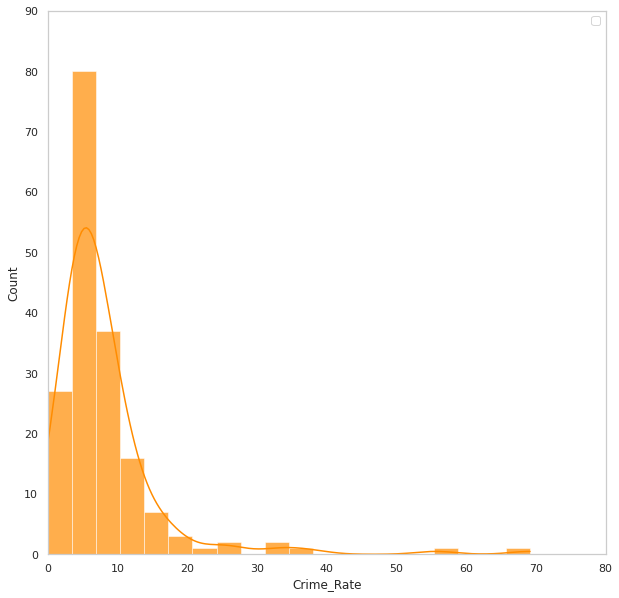

No handles with labels found to put in legend.


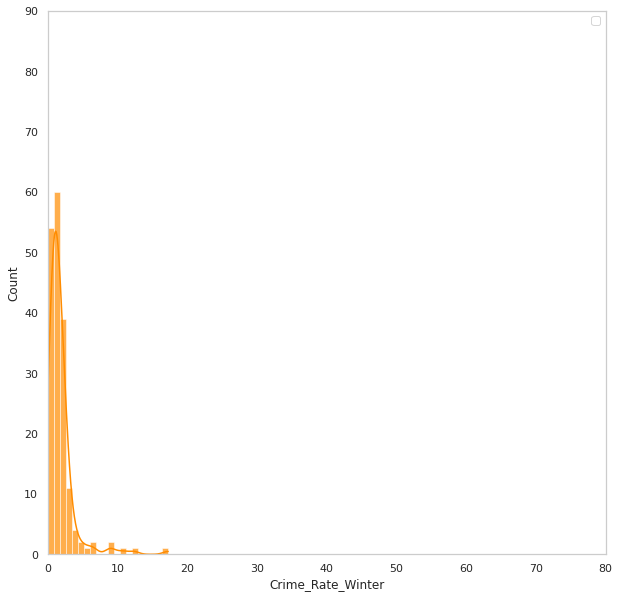

No handles with labels found to put in legend.


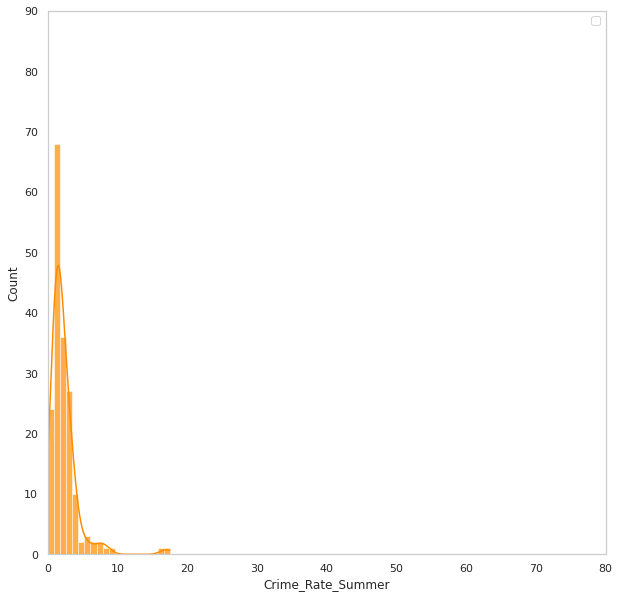

In [62]:
# Look at distribituion 

crimetype = ['Crime_Rate', 'Crime_Rate_Winter','Crime_Rate_Summer']

for c in crimetype:
    fig, axs = plt.subplots(1, figsize=(10,10))
    sns.set(style="whitegrid")

    sns.histplot(data=lambeth_lsoa, x=c, kde=True, color="darkorange", linewidth=0.5, alpha=0.7, bins=20)

    axs.set_xlabel(f"{c}")
    axs.set_ylabel("Count")
    
    plt.ylim([0,90])
    plt.xlim([0,80])

    axs.grid()
    plt.legend() 
    plt.show()
    fig.savefig(os.path.join("figures",f"{c}"), transparent=True)


> All negatively skewed, so will log

> Add 1 to stop 0 values, keeps the distribution the same

In [63]:
# Log data

lambeth_lsoa["Crime_Rate_Log"] = np.log(lambeth_lsoa["Crime_Rate"]+1)
lambeth_lsoa["Crime_Rate_Log_Winter"] = np.log(lambeth_lsoa["Crime_Rate_Winter"]+1)
lambeth_lsoa["Crime_Rate_Log_Summer"] = np.log(lambeth_lsoa["Crime_Rate_Summer"]+1)

<AxesSubplot:xlabel='Crime_Rate', ylabel='Count'>

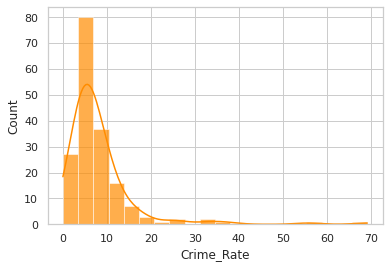

In [64]:
# Look at dsitributions

sns.histplot(data=lambeth_lsoa, x="Crime_Rate", kde=True, color="darkorange", linewidth=0.5, alpha=0.7, bins=20)

In [65]:
rates = ['Crime_Rate',
       'ASB_Crime_Rate', 'Public_order_Crime_Rate', 'Robbery_Crime_Rate',
       'Theft_Crime_Rate', 'Violence_Crime_Rate', 'Crime_Rate_Winter',
       'ASB_Crime_Rate_Winter', 'Public_order_Crime_Rate_Winter',
       'Robbery_Crime_Rate_Winter', 'Theft_Crime_Rate_Winter',
       'Violence_Crime_Rate_Winter', 'Crime_Rate_Summer',
       'ASB_Crime_Rate_Summer', 'Public_order_Crime_Rate_Summer',
       'Robbery_Crime_Rate_Summer', 'Theft_Crime_Rate_Summer',
       'Violence_Crime_Rate_Summer']

for r in rates:
    lambeth_lsoa[f"{r}_Log"] = np.log(lambeth_lsoa[r]+1)

No handles with labels found to put in legend.


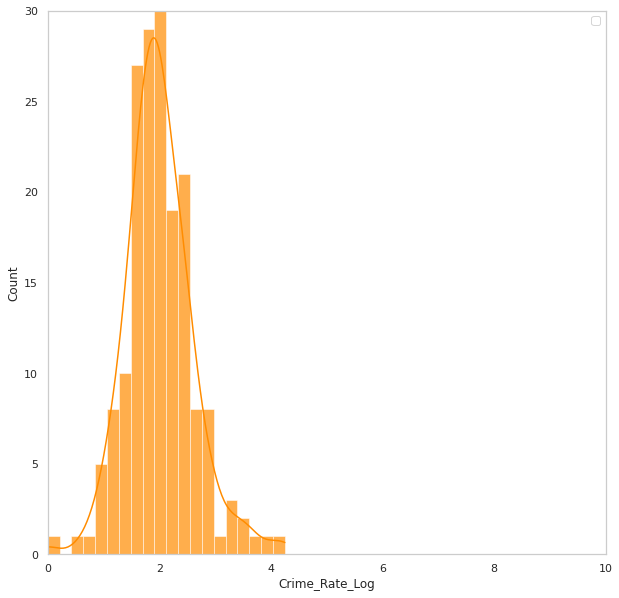

No handles with labels found to put in legend.


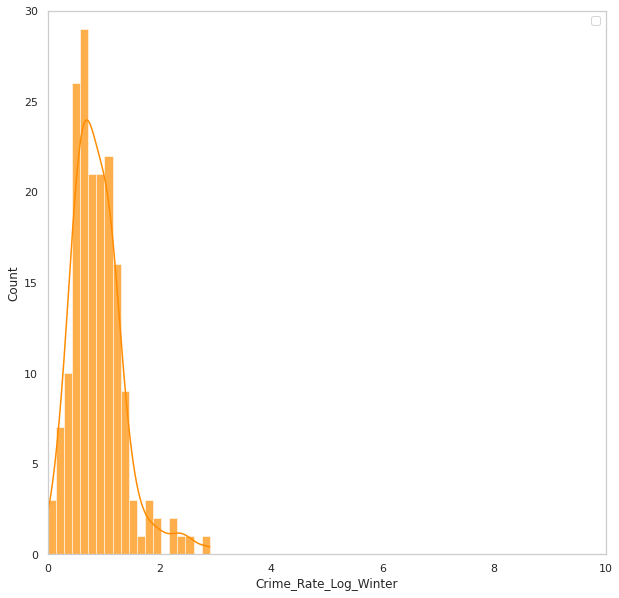

No handles with labels found to put in legend.


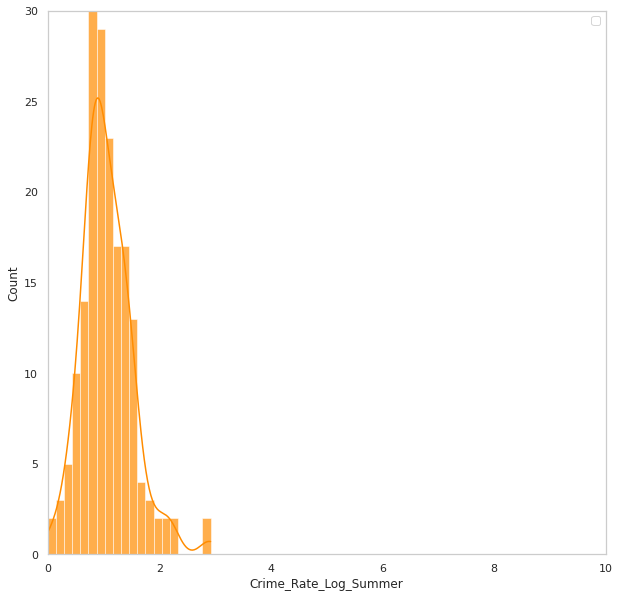

No handles with labels found to put in legend.


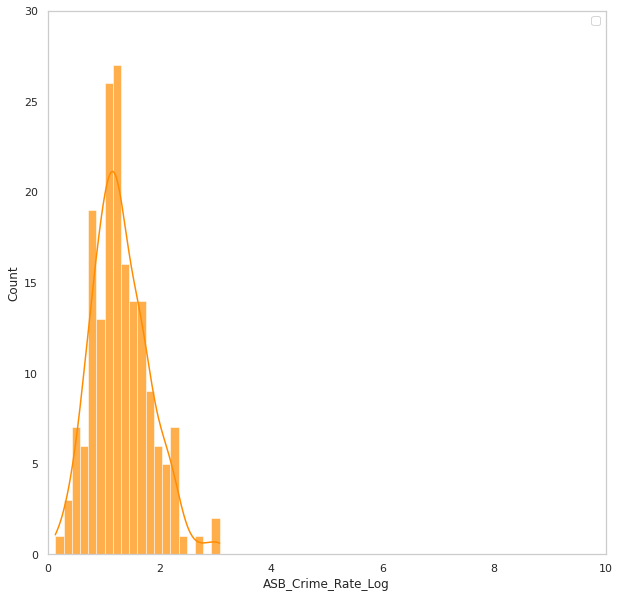

No handles with labels found to put in legend.


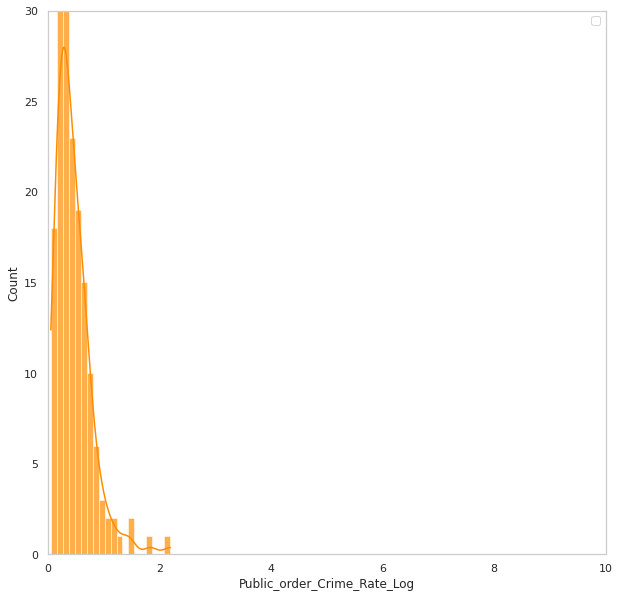

No handles with labels found to put in legend.


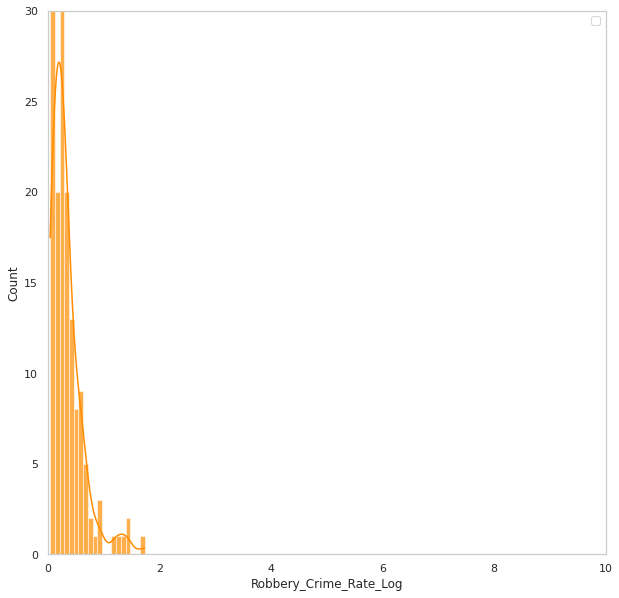

No handles with labels found to put in legend.


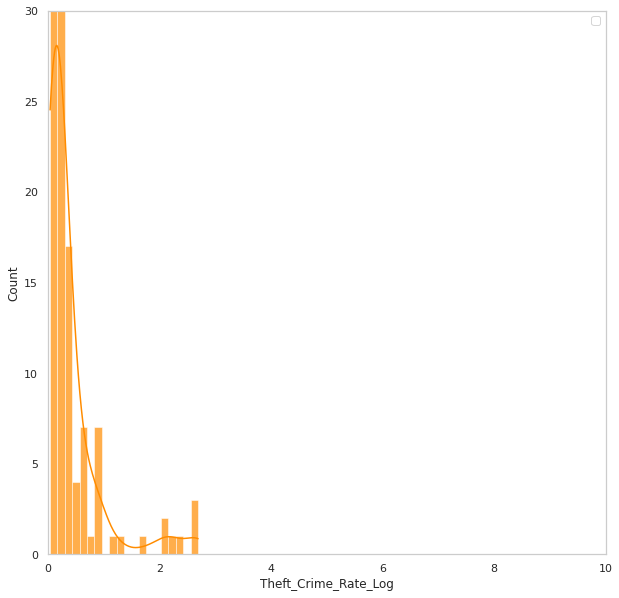

No handles with labels found to put in legend.


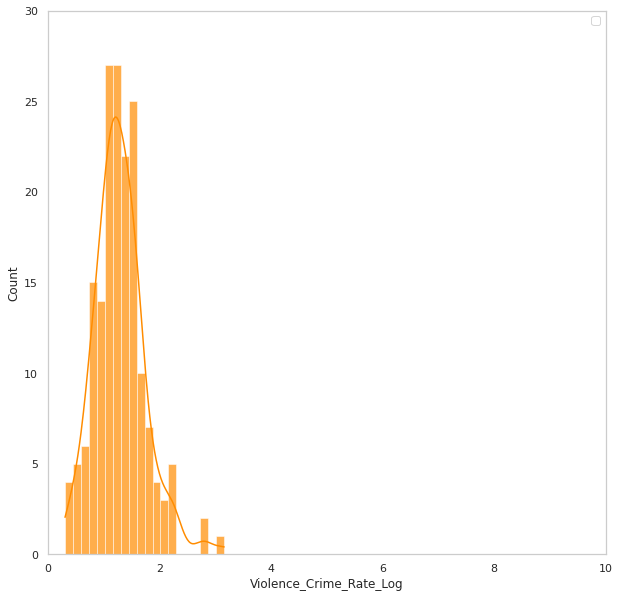

No handles with labels found to put in legend.


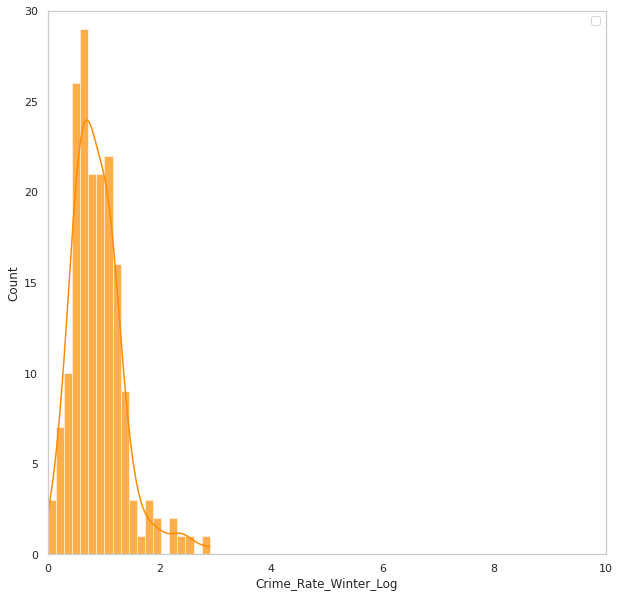

No handles with labels found to put in legend.


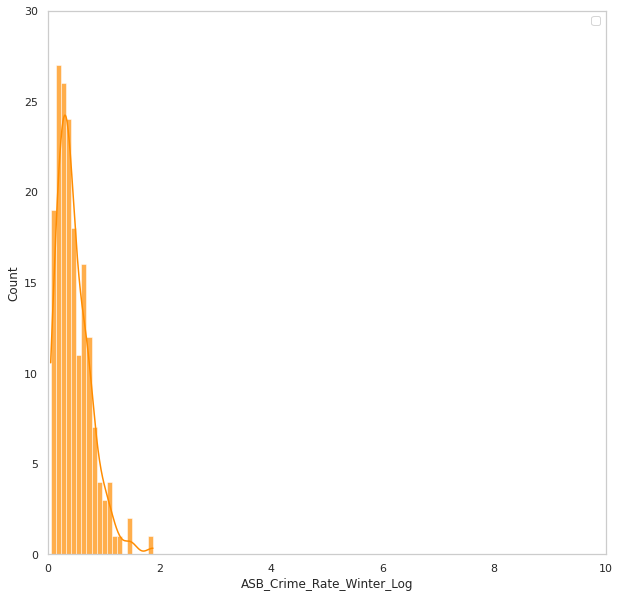

No handles with labels found to put in legend.


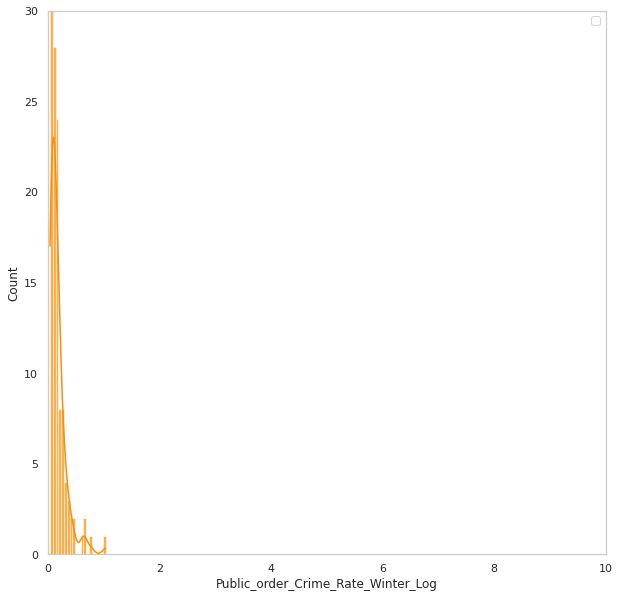

No handles with labels found to put in legend.


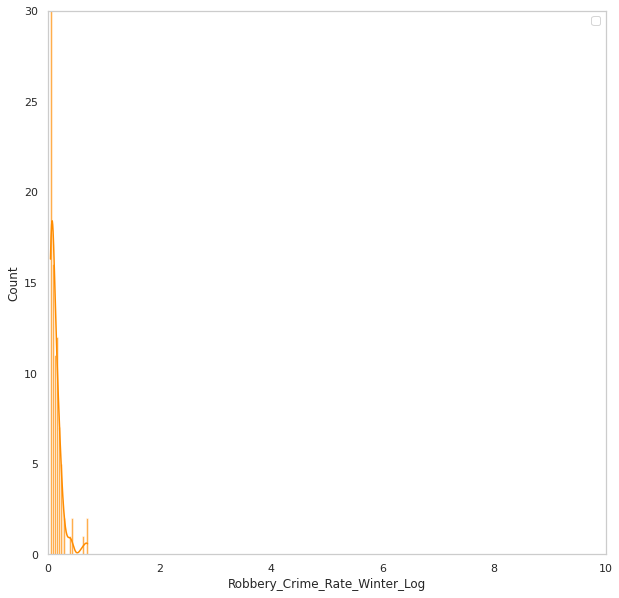

No handles with labels found to put in legend.


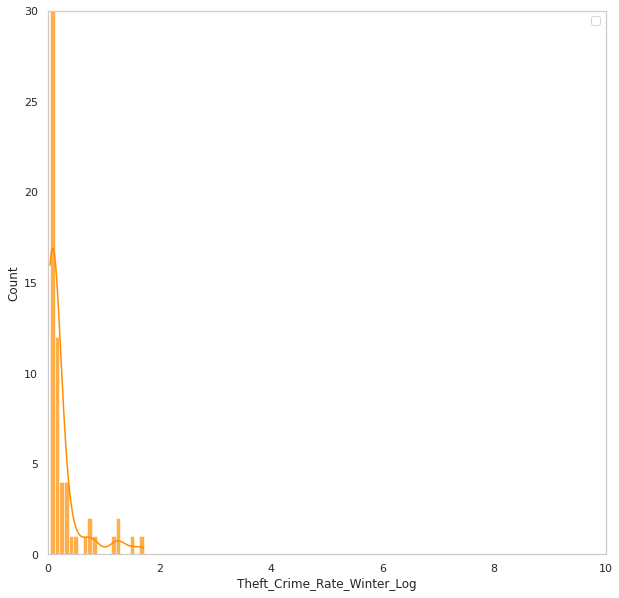

No handles with labels found to put in legend.


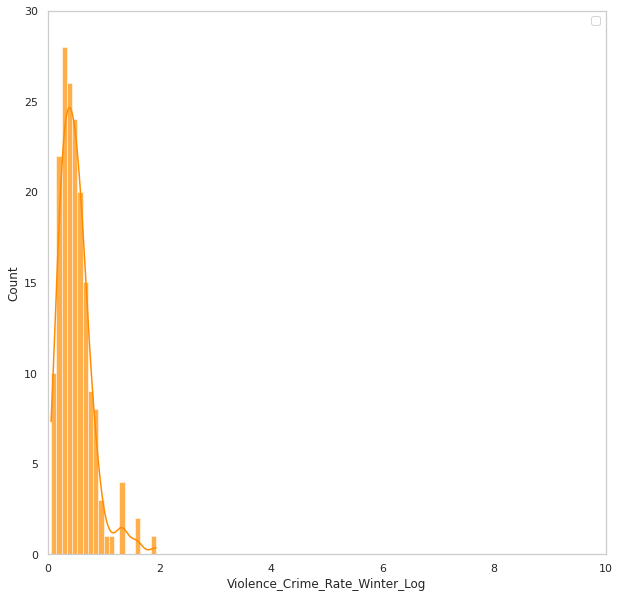

No handles with labels found to put in legend.


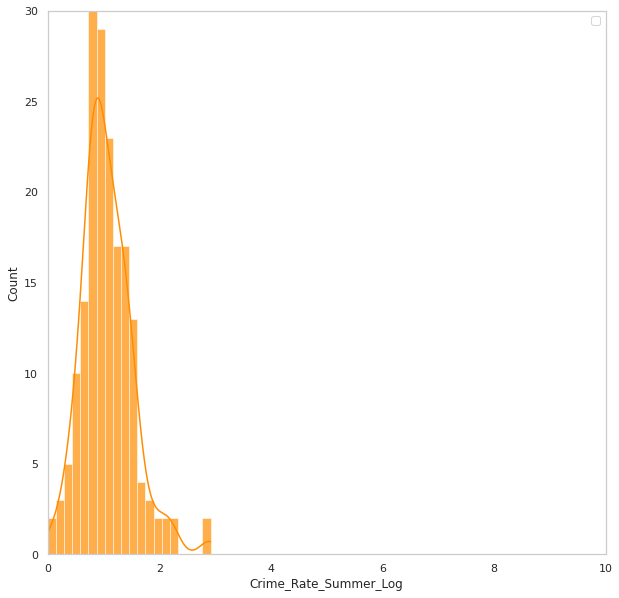

No handles with labels found to put in legend.


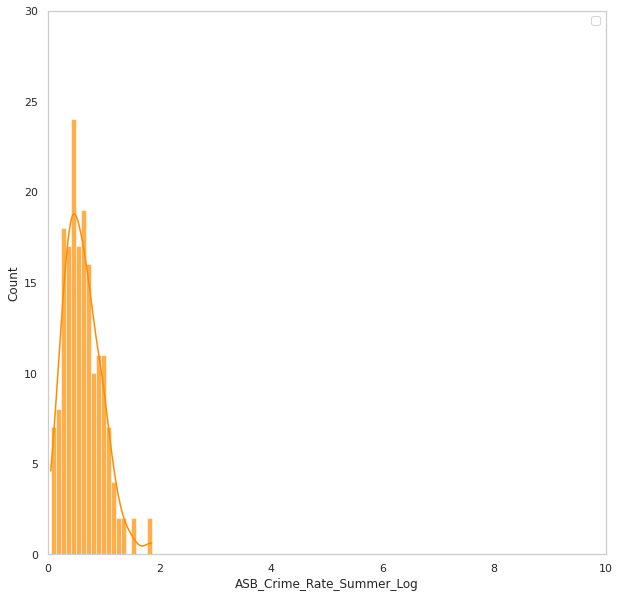

No handles with labels found to put in legend.


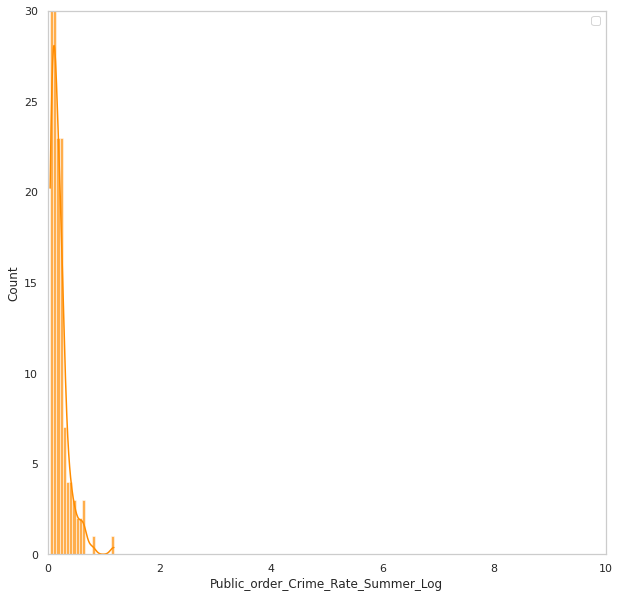

No handles with labels found to put in legend.


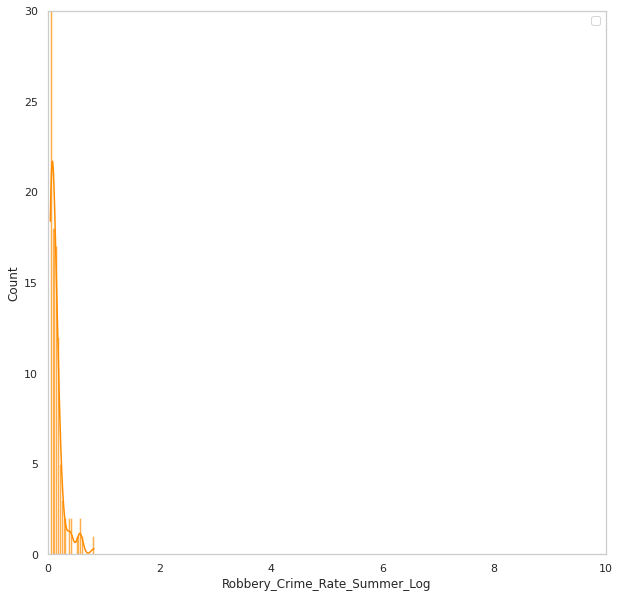

No handles with labels found to put in legend.


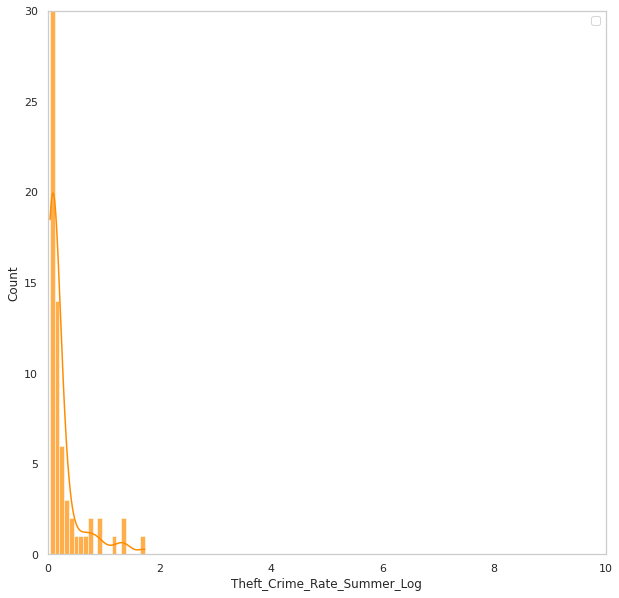

No handles with labels found to put in legend.


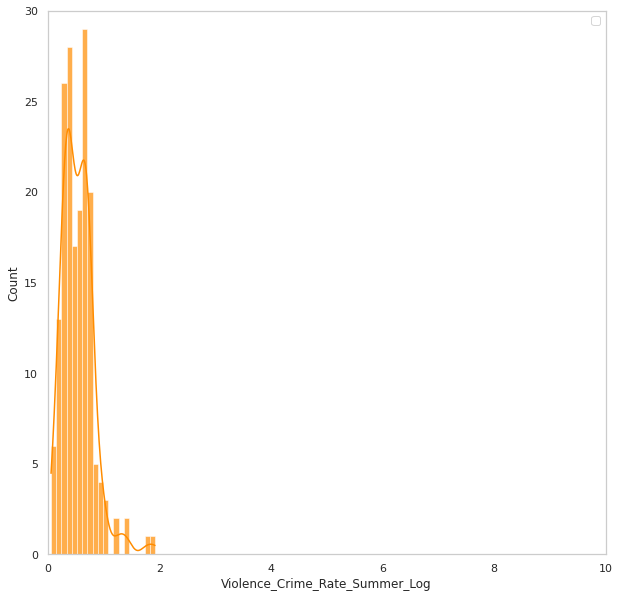

In [66]:
# Look at distribituion 

log = ['Crime_Rate_Log', 'Crime_Rate_Log_Winter',
       'Crime_Rate_Log_Summer', 'ASB_Crime_Rate_Log',
       'Public_order_Crime_Rate_Log', 'Robbery_Crime_Rate_Log',
       'Theft_Crime_Rate_Log', 'Violence_Crime_Rate_Log',
       'Crime_Rate_Winter_Log', 'ASB_Crime_Rate_Winter_Log',
       'Public_order_Crime_Rate_Winter_Log', 'Robbery_Crime_Rate_Winter_Log',
       'Theft_Crime_Rate_Winter_Log', 'Violence_Crime_Rate_Winter_Log',
       'Crime_Rate_Summer_Log', 'ASB_Crime_Rate_Summer_Log',
       'Public_order_Crime_Rate_Summer_Log', 'Robbery_Crime_Rate_Summer_Log',
       'Theft_Crime_Rate_Summer_Log', 'Violence_Crime_Rate_Summer_Log']

for l in log:
    fig, axs = plt.subplots(1, figsize=(10,10))
    sns.set(style="whitegrid")

    sns.histplot(data=lambeth_lsoa, x=l, kde=True, color="darkorange", linewidth=0.5, alpha=0.7, bins=20)

    axs.set_xlabel(f"{l}")
    axs.set_ylabel("Count")
    
    plt.ylim([0,30])
    plt.xlim([0,10])

    axs.grid()
    plt.legend() 
    plt.show()
    fig.savefig(os.path.join("figures",f"{l}_Log"), transparent=True)

# 7. Descriptive stats

In [67]:
rate_df = lambeth_lsoa[['Crime_Rate_Log', 'Crime_Rate_Log_Winter',
       'Crime_Rate_Log_Summer', 'ASB_Crime_Rate_Log',
       'Public_order_Crime_Rate_Log', 'Robbery_Crime_Rate_Log',
       'Theft_Crime_Rate_Log', 'Violence_Crime_Rate_Log',
       'Crime_Rate_Winter_Log', 'ASB_Crime_Rate_Winter_Log',
       'Public_order_Crime_Rate_Winter_Log', 'Robbery_Crime_Rate_Winter_Log',
       'Theft_Crime_Rate_Winter_Log', 'Violence_Crime_Rate_Winter_Log',
       'Crime_Rate_Summer_Log', 'ASB_Crime_Rate_Summer_Log',
       'Public_order_Crime_Rate_Summer_Log', 'Robbery_Crime_Rate_Summer_Log',
       'Theft_Crime_Rate_Summer_Log', 'Violence_Crime_Rate_Summer_Log']].copy()

In [68]:
rate_df.describe()

Crime_Rate_Log  Crime_Rate_Log_Winter  Crime_Rate_Log_Summer  \
count      178.000000             178.000000             178.000000   
mean         2.002585               0.891673               1.062652   
std          0.599754               0.466693               0.455846   
min          0.000000               0.000000               0.000000   
25%          1.646188               0.567209               0.774967   
50%          1.932710               0.814831               0.991690   
75%          2.356561               1.134145               1.314218   
max          4.250574               2.905318               2.918684   

       ASB_Crime_Rate_Log  Public_order_Crime_Rate_Log  \
count          177.000000                   171.000000   
mean             1.308038                     0.457798   
std              0.509263                     0.324812   
min              0.135986                     0.056672   
25%              0.964788                     0.228356   
50%              1.248436                     0.369887   
75%              1.623863                     0.594887   
max              3.080736                     2.196131   

       Robbery_Crime_Rate_Log  Theft_Crime_Rate_Log  Violence_Crime_Rate_Log  \
count              167.000000            147.000000               177.000000   
mean                 0.329676              0.372193                 1.291593   
std                  0.287153              0.531139                 0.451955   
min                  0.042962              0.042962                 0.310543   
25%                  0.126795              0.087559                 1.036497   
50%                  0.257829              0.184771                 1.237499   
75%                  0.400853              0.393484                 1.552303   
max                  1.735396              2.694909                 3.162023   

       Crime_Rate_Winter_Log  ASB_Crime_Rate_Winter_Log  \
count             178.000000                 176.000000   
mean                0.891673                   0.462349   
std                 0.466693                   0.307592   
min                 0.000000                   0.053690   
25%                 0.567209                   0.234233   
50%                 0.814831                   0.384544   
75%                 1.134145                   0.631981   
max                 2.905318                   1.886026   

       Public_order_Crime_Rate_Winter_Log  Robbery_Crime_Rate_Winter_Log  \
count                          120.000000                     110.000000   
mean                             0.175612                       0.137542   
std                              0.157047                       0.121399   
min                              0.041158                       0.049712   
25%                              0.065924                       0.059032   
50%                              0.121624                       0.104534   
75%                              0.199736                       0.173294   
max                              1.040413                       0.714585   

       Theft_Crime_Rate_Winter_Log  Violence_Crime_Rate_Winter_Log  \
count                    88.000000                      174.000000   
mean                      0.216516                        0.497698   
std                       0.337917                        0.300636   
min                       0.041431                        0.060515   
25%                       0.056842                        0.288378   
50%                       0.099635                        0.447076   
75%                       0.155366                        0.623293   
max                       1.718228                        1.940451   

       Crime_Rate_Summer_Log  ASB_Crime_Rate_Summer_Log  \
count             178.000000                 177.000000   
mean                1.062652                   0.629085   
std                 0.455846                   0.338441   
min                 0.000000           

# 8. T Test

In [69]:
import scipy.stats as sps

alpha=0.05

In [70]:
# Fill NaN values with 0

rate_df = rate_df.fillna(0)

In [71]:
# See if crime rates are different 

print("H0: Crime rate in summer is no different then crime ratae overall")
print("H1: Crime rate in summer is different then crime rate overall")

test_stat, p_value = sps.ttest_ind(rate_df["Crime_Rate_Log"],rate_df["Crime_Rate_Log_Summer"])
print("T Statistic =", test_stat)
print("p-value =", p_value)

if p_value < alpha:
    print(f"p-value < significance threshold of {alpha}.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

H0: Crime rate in summer is no different then crime ratae overall
H1: Crime rate in summer is different then crime rate overall
T Statistic = 16.64653977420452
p-value = 2.288898528372369e-46
p-value < significance threshold of 0.05.
Reject H0. Accept H1.
Conclude that samples are drawn from populations with different means.


In [72]:
print("H0: Crime rate in winter is no different then crime ratae overall")
print("H1: Crime rate in winter is different then crime rate overall")

test_stat, p_value = sps.ttest_ind(rate_df["Crime_Rate_Log"],rate_df["Crime_Rate_Log_Winter"])
print("T Statistic =", test_stat)
print("p-value =", p_value)

if p_value < alpha:
    print(f"p-value < significance threshold of {alpha}.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

H0: Crime rate in winter is no different then crime ratae overall
H1: Crime rate in winter is different then crime rate overall
T Statistic = 19.503431059245308
p-value = 4.721093454964747e-58
p-value < significance threshold of 0.05.
Reject H0. Accept H1.
Conclude that samples are drawn from populations with different means.


In [73]:
print("H0: Crime rate in summer is no different then crime rate in winter")
print("H1: Crime rate in summer is different then crime rate in winter")

test_stat, p_value = sps.ttest_ind(rate_df["Crime_Rate_Log_Summer"],rate_df["Crime_Rate_Log_Winter"])
print("T Statistic =", test_stat)
print("p-value =", p_value)

if p_value < alpha:
    print(f"p-value < significance threshold of {alpha}.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

H0: Crime rate in summer is no different then crime rate in winter
H1: Crime rate in summer is different then crime rate in winter
T Statistic = 3.4966634944745714
p-value = 0.0005310553428548294
p-value < significance threshold of 0.05.
Reject H0. Accept H1.
Conclude that samples are drawn from populations with different means.


In [74]:
print("H0: Crime rate in summer is no different then crime rate in winter")
print("H1: Crime rate in summer is different then crime rate in winter")

test_stat, p_value = sps.ttest_ind(rate_df["Crime_Rate_Log_Winter"],rate_df["Crime_Rate_Log_Summer"])
print("T Statistic =", test_stat)
print("p-value =", p_value)

if p_value < alpha:
    print(f"p-value < significance threshold of {alpha}.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

H0: Crime rate in summer is no different then crime rate in winter
H1: Crime rate in summer is different then crime rate in winter
T Statistic = -3.4966634944745714
p-value = 0.0005310553428548294
p-value < significance threshold of 0.05.
Reject H0. Accept H1.
Conclude that samples are drawn from populations with different means.


In [75]:
print("H0: Crime rate in summer is no different then ASB crime rate in winter")
print("H1: Crime rate in summer is different then ASB crime rate in winter")

std_ratio = rate_df["ASB_Crime_Rate_Winter_Log"].std()/rate_df["ASB_Crime_Rate_Winter_Log"].std()

if std_ratio > 0.5 and std_ratio < 2:
    equal_stds = True
else:
    equal_stds = False

test_stat, p_value = sps.ttest_ind(rate_df["ASB_Crime_Rate_Winter_Log"],rate_df["ASB_Crime_Rate_Summer_Log"], equal_var=equal_stds)
print("T Statistic =", test_stat)
print("p-value =", p_value)

if p_value < alpha:
    print(f"p-value < significance threshold of {alpha}.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

H0: Crime rate in summer is no different then ASB crime rate in winter
H1: Crime rate in summer is different then ASB crime rate in winter
T Statistic = -4.878941705499761
p-value = 1.6153333863087941e-06
p-value < significance threshold of 0.05.
Reject H0. Accept H1.
Conclude that samples are drawn from populations with different means.


In [76]:
print("H0: Crime rate in summer is no different then Public_Order crime rate in winter")
print("H1: Crime rate in summer is different then Public_Order crime rate in winter")

std_ratio = rate_df["Public_order_Crime_Rate_Winter_Log"].std()/rate_df["Public_order_Crime_Rate_Winter_Log"].std()

if std_ratio > 0.5 and std_ratio < 2:
    equal_stds = True
else:
    equal_stds = False

test_stat, p_value = sps.ttest_ind(rate_df["Public_order_Crime_Rate_Winter_Log"],rate_df["Public_order_Crime_Rate_Summer_Log"], equal_var=equal_stds)
print("T Statistic =", test_stat)
print("p-value =", p_value)

if p_value < alpha:
    print(f"p-value < significance threshold of {alpha}.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

H0: Crime rate in summer is no different then Public_Order crime rate in winter
H1: Crime rate in summer is different then Public_Order crime rate in winter
T Statistic = -2.675274652310962
p-value = 0.007813539595415827
p-value < significance threshold of 0.05.
Reject H0. Accept H1.
Conclude that samples are drawn from populations with different means.


In [77]:
print("H0: Crime rate in summer is no different then Robbery crime rate in winter")
print("H1: Crime rate in summer is different then Robbery crime rate in winter")

std_ratio = rate_df["Robbery_Crime_Rate_Winter_Log"].std()/rate_df["Robbery_Crime_Rate_Winter_Log"].std()

if std_ratio > 0.5 and std_ratio < 2:
    equal_stds = True
else:
    equal_stds = False

test_stat, p_value = sps.ttest_ind(rate_df["Robbery_Crime_Rate_Winter_Log"],rate_df["Robbery_Crime_Rate_Summer_Log"], equal_var=equal_stds)
print("T Statistic =", test_stat)
print("p-value =", p_value)

if p_value < alpha:
    print(f"p-value < significance threshold of {alpha}.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

H0: Crime rate in summer is no different then Robbery crime rate in winter
H1: Crime rate in summer is different then Robbery crime rate in winter
T Statistic = -0.6576709611572749
p-value = 0.5111769950565221
p-value >= significance threshold.
No significant evidence to reject H0.
Assume samples are drawn from populations with the same mean.


In [78]:
print("H0: Crime rate in summer is no different then Theft crime rate in winter")
print("H1: Crime rate in summer is different then Theft crime rate in winter")

std_ratio = rate_df["Theft_Crime_Rate_Winter_Log"].std()/rate_df["Theft_Crime_Rate_Winter_Log"].std()

if std_ratio > 0.5 and std_ratio < 2:
    equal_stds = True
else:
    equal_stds = False

test_stat, p_value = sps.ttest_ind(rate_df["Theft_Crime_Rate_Winter_Log"],rate_df["Theft_Crime_Rate_Summer_Log"], equal_var=equal_stds)
print("T Statistic =", test_stat)
print("p-value =", p_value)

if p_value < alpha:
    print(f"p-value < significance threshold of {alpha}.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

H0: Crime rate in summer is no different then Theft crime rate in winter
H1: Crime rate in summer is different then Theft crime rate in winter
T Statistic = -0.38452433770473915
p-value = 0.70082075280571
p-value >= significance threshold.
No significant evidence to reject H0.
Assume samples are drawn from populations with the same mean.


In [79]:
print("H0: Crime rate in summer is no different then Violence crime rate in winter")
print("H1: Crime rate in summer is different then Violence crime rate in winter")

std_ratio = rate_df["Violence_Crime_Rate_Winter_Log"].std()/rate_df["Violence_Crime_Rate_Winter_Log"].std()

if std_ratio > 0.5 and std_ratio < 2:
    equal_stds = True
else:
    equal_stds = False

test_stat, p_value = sps.ttest_ind(rate_df["Violence_Crime_Rate_Winter_Log"],rate_df["Violence_Crime_Rate_Summer_Log"], equal_var=equal_stds)
print("T Statistic =", test_stat)
print("p-value =", p_value)

if p_value < alpha:
    print(f"p-value < significance threshold of {alpha}.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

H0: Crime rate in summer is no different then Violence crime rate in winter
H1: Crime rate in summer is different then Violence crime rate in winter
T Statistic = -1.618191205092851
p-value = 0.10651200300293853
p-value >= significance threshold.
No significant evidence to reject H0.
Assume samples are drawn from populations with the same mean.


# 9. Multiple Regression

In [80]:
# Find nearest light to crime

lambeth_dem = lambeth_dem.rename(columns={"Codes":"LSOA11CD"})

In [81]:
# Merge demographic data in
lambeth_lsoa = pd.merge(lambeth_lsoa,lambeth_dem, on="LSOA11CD", how="left")

In [82]:
lambeth_lsoa.columns.tolist()

['LSOA11CD',
 'LSOA11NM',
 'MSOA11CD',
 'MSOA11NM',
 'LAD11CD',
 'LAD11NM',
 'RGN11CD',
 'RGN11NM',
 'USUALRES',
 'HHOLDRES',
 'COMESTRES',
 'POPDEN',
 'HHOLDS',
 'AVHHOLDSZ',
 'geometry',
 'GreenspaceArea',
 'RoadsArea',
 'Owned',
 'SharedOwnshp',
 'SocialRented',
 'PrivateRented',
 'RentFree',
 'ORroomsM1',
 'ORbedsM1',
 'RoomsHH',
 'BedsHH',
 'White',
 'MultiEthnic',
 'Asian',
 'Black',
 'OtherEthnic',
 'MedianIncome',
 'Area',
 'lightcount',
 'light_density',
 'ASB_Count',
 'Public_Order_Count',
 'Robbery_Count',
 'Theft_From_Persons_Count',
 'Violence_Count',
 'ASB_Count_Winter',
 'Public_Order_Count_Winter',
 'Robbery_Count_Winter',
 'Theft_From_Persons_Count_Winter',
 'Violence_Count_Winter',
 'ASB_Count_Summer',
 'Public_Order_Count_Summer',
 'Robbery_Count_Summer',
 'Theft_From_Persons_Count_Summer',
 'Violence_Count_Summer',
 'Crime_Count',
 'Crime_Count_Winter',
 'Crime_Count_Summer',
 'Crime_Rate',
 'ASB_Crime_Rate',
 'Public_order_Crime_Rate',
 'Robbery_Crime_Rate',
 'Thef

In [83]:
# Overall crime rate

Y = lambeth_lsoa["Crime_Count"]
X = lambeth_lsoa[["lightcount",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_0=sm.OLS(Y,X).fit()

model_0.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime_Count   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     17.52
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           1.59e-21
Time:                        16:38:23   Log-Likelihood:                -1060.7
No. Observations:                 178   AIC:                             2143.
Df Residuals:                     167   BIC:                             2178.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                       -673.4121    164.358     -4.097      0.000    -997.899    -348.925
lightcount                                                     1.6773      0.201      8.350      0.000       1.281       2.074
Index of Multiple Deprivation (IMD) Score                      5.8002      2.042      2.841      0.005       1.769       9.831
Lone parent household (%)                                     -6.7492      3.184     -2.119      0.036     -13.036      -0.462
BAME (%)                                                       4.5166      1.442      3.131      0.002       1.669       7.364
Social rented (%)                                              3.8163      1.015      3.761      0.000       1.813       5.820
Private rented (%)                                             6.0622      1.323      4.581      0.000       3.450       8.675
Highest level of qualification: Level 2 qualifications (%)    -0.3313      6.578     -0.050      0.960     -13.317      12.655
Unemployment Rate (%)                                         -6.7786      6.092     -1.113      0.267     -18.806       5.249
Median Household Income                                        0.0043      0.002      2.143      0.034       0.000       0.008
English not first language (%)                                 2.2449      2.077      1.081      0.281      -1.855       6.345
==============================================================================
Omnibus:                      110.667   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1059.544
Skew:                           2.139   Prob(JB):                    8.38e-231
Kurtosis:                      14.161   Cond. No.                     8.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

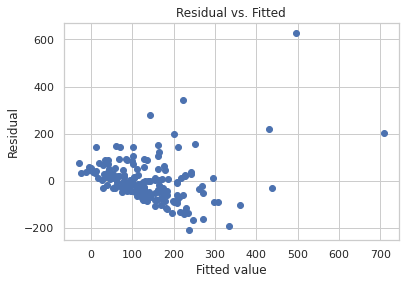

In [84]:
# Check residuals 

# residual plot 
plt.scatter(model_0.fittedvalues, model_0.resid)
# adding title and labels
plt.xlabel('Fitted value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted')
plt.show()

In [85]:
X_drop = drop_column_using_vif_(X)

Dropping: Lone parent household (%)
Dropping: Median Household Income
Dropping: Unemployment Rate (%)
Dropping: Social rented (%)
Dropping: BAME (%)


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [86]:
Y = lambeth_lsoa["Crime_Count"]
X = lambeth_lsoa[["lightcount",  'Index of Multiple Deprivation (IMD) Score',
  

 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_2=sm.OLS(Y,X).fit()

model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime_Count   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     26.94
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           4.54e-20
Time:                        16:38:24   Log-Likelihood:                -1073.0
No. Observations:                 178   AIC:                             2158.
Df Residuals:                     172   BIC:                             2177.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                       -223.8855     66.227     -3.381      0.001    -354.608     -93.163
lightcount                                                     1.7139      0.204      8.385      0.000       1.310       2.117
Index of Multiple Deprivation (IMD) Score                      7.9277      1.244      6.373      0.000       5.472      10.383
Private rented (%)                                             2.6414      1.013      2.608      0.010       0.642       4.640
Highest level of qualification: Level 2 qualifications (%)   -12.3446      4.558     -2.709      0.007     -21.341      -3.349
English not first language (%)                                 4.8265      1.704      2.833      0.005       1.463       8.190
==============================================================================
Omnibus:                      118.565   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1062.897
Skew:                           2.387   Prob(JB):                    1.57e-231
Kurtosis:                      13.978   Cond. No.                         833.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
# Overall crime rate

Y = lambeth_lsoa["Crime_Rate"]
X = lambeth_lsoa[["lightcount",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_3=sm.OLS(Y,X).fit()

model_3.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Crime_Rate   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     14.45
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           2.76e-18
Time:                        16:38:24   Log-Likelihood:                -570.14
No. Observations:                 178   AIC:                             1162.
Df Residuals:                     167   BIC:                             1197.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                        -43.4460     10.446     -4.159      0.000     -64.070     -22.822
lightcount                                                     0.0904      0.013      7.077      0.000       0.065       0.116
Index of Multiple Deprivation (IMD) Score                      0.4267      0.130      3.288      0.001       0.171       0.683
Lone parent household (%)                                     -0.5269      0.202     -2.603      0.010      -0.926      -0.127
BAME (%)                                                       0.2850      0.092      3.109      0.002       0.104       0.466
Social rented (%)                                              0.2257      0.065      3.499      0.001       0.098       0.353
Private rented (%)                                             0.3303      0.084      3.927      0.000       0.164       0.496
Highest level of qualification: Level 2 qualifications (%)     0.2108      0.418      0.504      0.615      -0.615       1.036
Unemployment Rate (%)                                         -0.5136      0.387     -1.326      0.186      -1.278       0.251
Median Household Income                                        0.0003      0.000      2.449      0.015    6.09e-05       0.001
English not first language (%)                                 0.1709      0.132      1.295      0.197      -0.090       0.431
==============================================================================
Omnibus:                      119.710   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1229.059
Skew:                           2.355   Prob(JB):                    1.30e-267
Kurtosis:                      14.981   Cond. No.                     8.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
X_drop = drop_column_using_vif_(X)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dropping: Lone parent household (%)
Dropping: Median Household Income
Dropping: Unemployment Rate (%)
Dropping: Social rented (%)
Dropping: BAME (%)


In [89]:
Y = lambeth_lsoa["Crime_Rate"]
X = lambeth_lsoa[["lightcount",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_4=sm.OLS(Y,X).fit()

model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Crime_Rate   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     21.36
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           1.37e-16
Time:                        16:38:24   Log-Likelihood:                -582.64
No. Observations:                 178   AIC:                             1177.
Df Residuals:                     172   BIC:                             1196.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                        -12.5355      4.212     -2.976      0.003     -20.850      -4.221
lightcount                                                     0.0950      0.013      7.309      0.000       0.069       0.121
Index of Multiple Deprivation (IMD) Score                      0.4736      0.079      5.985      0.000       0.317       0.630
Private rented (%)                                             0.1431      0.064      2.221      0.028       0.016       0.270
Highest level of qualification: Level 2 qualifications (%)    -0.7278      0.290     -2.511      0.013      -1.300      -0.156
English not first language (%)                                 0.2828      0.108      2.610      0.010       0.069       0.497
==============================================================================
Omnibus:                      134.708   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1447.205
Skew:                           2.767   Prob(JB):                         0.00
Kurtosis:                      15.826   Cond. No.                         833.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
Y = lambeth_lsoa["Crime_Rate_Log"]
X = lambeth_lsoa[["lightcount",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_5=sm.OLS(Y,X).fit()

model_5.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Crime_Rate_Log   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     14.68
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           1.52e-18
Time:                        16:38:25   Log-Likelihood:                -104.92
No. Observations:                 178   AIC:                             231.8
Df Residuals:                     167   BIC:                             266.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -0.7339      0.765     -0.959      0.339      -2.245       0.777
lightcount                                                     0.0056      0.001      5.955      0.000       0.004       0.007
Index of Multiple Deprivation (IMD) Score                      0.0361      0.010      3.798      0.000       0.017       0.055
Lone parent household (%)                                     -0.0334      0.015     -2.251      0.026      -0.063      -0.004
BAME (%)                                                       0.0137      0.007      2.036      0.043       0.000       0.027
Social rented (%)                                              0.0128      0.005      2.713      0.007       0.003       0.022
Private rented (%)                                             0.0261      0.006      4.230      0.000       0.014       0.038
Highest level of qualification: Level 2 qualifications (%)    -0.0003      0.031     -0.010      0.992      -0.061       0.060
Unemployment Rate (%)                                         -0.0284      0.028     -1.000      0.319      -0.084       0.028
Median Household Income                                     5.487e-06   9.39e-06      0.585      0.560    -1.3e-05     2.4e-05
English not first language (%)                                 0.0080      0.010      0.828      0.409      -0.011       0.027
==============================================================================
Omnibus:                        3.098   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.212   Jarque-Bera (JB):                3.405
Skew:                          -0.030   Prob(JB):                        0.182
Kurtosis:                       3.675   Cond. No.                     8.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [91]:
Y = lambeth_lsoa["Crime_Rate_Log"]
X = lambeth_lsoa[["lightcount",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_6=sm.OLS(Y,X).fit()

model_6.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Crime_Rate_Log   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     25.67
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           2.67e-19
Time:                        16:38:25   Log-Likelihood:                -111.46
No. Observations:                 178   AIC:                             234.9
Df Residuals:                     172   BIC:                             254.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.1410      0.298      0.472      0.637      -0.448       0.730
lightcount                                                     0.0057      0.001      6.138      0.000       0.004       0.007
Index of Multiple Deprivation (IMD) Score                      0.0443      0.006      7.910      0.000       0.033       0.055
Private rented (%)                                             0.0168      0.005      3.676      0.000       0.008       0.026
Highest level of qualification: Level 2 qualifications (%)    -0.0483      0.021     -2.350      0.020      -0.089      -0.008
English not first language (%)                                 0.0188      0.008      2.446      0.015       0.004       0.034
==============================================================================
Omnibus:                        8.744   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               10.707
Skew:                           0.353   Prob(JB):                      0.00473
Kurtosis:                       3.972   Cond. No.                         833.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

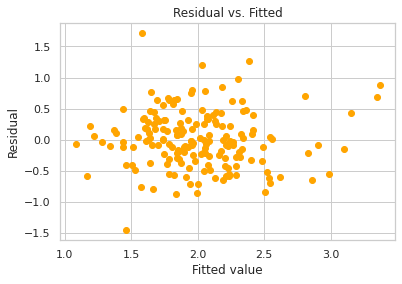

<Figure size 432x288 with 0 Axes>

In [92]:
plt.scatter(model_6.fittedvalues, model_6.resid, color="orange")
# adding title and labels
plt.xlabel('Fitted value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted')
plt.show()
plt.savefig("residuals")

In [93]:
Y = lambeth_lsoa["Crime_Count"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_7=sm.OLS(Y,X).fit()

model_7.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime_Count   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     8.123
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           1.22e-10
Time:                        16:38:25   Log-Likelihood:                -1089.2
No. Observations:                 178   AIC:                             2200.
Df Residuals:                     167   BIC:                             2235.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                       -776.4856    201.590     -3.852      0.000   -1174.479    -378.492
light_density                                               1.054e+05   4.85e+04      2.173      0.031    9645.805    2.01e+05
Index of Multiple Deprivation (IMD) Score                      7.0286      2.390      2.940      0.004       2.309      11.748
Lone parent household (%)                                     -9.3499      3.721     -2.513      0.013     -16.696      -2.004
BAME (%)                                                       6.3415      1.672      3.792      0.000       3.040       9.643
Social rented (%)                                              3.0316      1.190      2.548      0.012       0.682       5.381
Private rented (%)                                             6.5504      1.556      4.210      0.000       3.479       9.622
Highest level of qualification: Level 2 qualifications (%)     4.7329      7.901      0.599      0.550     -10.865      20.331
Unemployment Rate (%)                                         -8.2475      7.150     -1.154      0.250     -22.363       5.868
Median Household Income                                        0.0070      0.002      2.947      0.004       0.002       0.012
English not first language (%)                                 1.4463      2.436      0.594      0.553      -3.363       6.255
==============================================================================
Omnibus:                      135.965   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1822.639
Skew:                           2.694   Prob(JB):                         0.00
Kurtosis:                      17.721   Cond. No.                     2.11e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
Y = lambeth_lsoa["Crime_Count"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_8=sm.OLS(Y,X).fit()

model_8.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime_Count   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     9.937
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           2.30e-08
Time:                        16:38:25   Log-Likelihood:                -1101.9
No. Observations:                 178   AIC:                             2216.
Df Residuals:                     172   BIC:                             2235.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                       -130.5086     83.568     -1.562      0.120    -295.460      34.443
light_density                                               8.964e+04   5.07e+04      1.769      0.079   -1.04e+04     1.9e+05
Index of Multiple Deprivation (IMD) Score                      6.1799      1.442      4.286      0.000       3.334       9.026
Private rented (%)                                             3.8953      1.177      3.309      0.001       1.571       6.219
Highest level of qualification: Level 2 qualifications (%)    -9.2893      5.482     -1.694      0.092     -20.111       1.532
English not first language (%)                                 2.9538      1.987      1.487      0.139      -0.968       6.876
==============================================================================
Omnibus:                      163.734   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2890.054
Skew:                           3.425   Prob(JB):                         0.00
Kurtosis:                      21.513   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
Y = lambeth_lsoa["Crime_Rate"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_9=sm.OLS(Y,X).fit()

model_9.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Crime_Rate   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     7.962
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           2.00e-10
Time:                        16:38:25   Log-Likelihood:                -590.92
No. Observations:                 178   AIC:                             1204.
Df Residuals:                     167   BIC:                             1239.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                        -50.0066     12.264     -4.077      0.000     -74.220     -25.794
light_density                                               6517.5955   2951.994      2.208      0.029     689.560    1.23e+04
Index of Multiple Deprivation (IMD) Score                      0.4924      0.145      3.386      0.001       0.205       0.780
Lone parent household (%)                                     -0.6670      0.226     -2.947      0.004      -1.114      -0.220
BAME (%)                                                       0.3822      0.102      3.757      0.000       0.181       0.583
Social rented (%)                                              0.1858      0.072      2.567      0.011       0.043       0.329
Private rented (%)                                             0.3582      0.095      3.784      0.000       0.171       0.545
Highest level of qualification: Level 2 qualifications (%)     0.5126      0.481      1.066      0.288      -0.436       1.462
Unemployment Rate (%)                                         -0.5905      0.435     -1.357      0.176      -1.449       0.268
Median Household Income                                        0.0005      0.000      3.205      0.002       0.000       0.001
English not first language (%)                                 0.1295      0.148      0.874      0.383      -0.163       0.422
==============================================================================
Omnibus:                      138.197   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1922.848
Skew:                           2.742   Prob(JB):                         0.00
Kurtosis:                      18.139   Cond. No.                     2.11e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
Y = lambeth_lsoa["Crime_Rate"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_10=sm.OLS(Y,X).fit()

model_10.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Crime_Rate   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     8.911
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           1.52e-07
Time:                        16:38:26   Log-Likelihood:                -605.12
No. Observations:                 178   AIC:                             1222.
Df Residuals:                     172   BIC:                             1241.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -7.7317      5.127     -1.508      0.133     -17.852       2.389
light_density                                               5471.7627   3108.414      1.760      0.080    -663.787    1.16e+04
Index of Multiple Deprivation (IMD) Score                      0.3768      0.088      4.260      0.000       0.202       0.551
Private rented (%)                                             0.2122      0.072      2.937      0.004       0.070       0.355
Highest level of qualification: Level 2 qualifications (%)    -0.5469      0.336     -1.626      0.106      -1.211       0.117
English not first language (%)                                 0.1790      0.122      1.468      0.144      -0.062       0.420
==============================================================================
Omnibus:                      171.651   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3322.872
Skew:                           3.643   Prob(JB):                         0.00
Kurtosis:                      22.873   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
Y = lambeth_lsoa["Crime_Rate_Log"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_11=sm.OLS(Y,X).fit()

model_11.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Crime_Rate_Log   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     9.290
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           3.71e-12
Time:                        16:38:26   Log-Likelihood:                -121.71
No. Observations:                 178   AIC:                             265.4
Df Residuals:                     167   BIC:                             300.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -0.8611      0.879     -0.980      0.329      -2.596       0.874
light_density                                                171.4055    211.491      0.810      0.419    -246.135     588.946
Index of Multiple Deprivation (IMD) Score                      0.0403      0.010      3.866      0.000       0.020       0.061
Lone parent household (%)                                     -0.0420      0.016     -2.591      0.010      -0.074      -0.010
BAME (%)                                                       0.0200      0.007      2.741      0.007       0.006       0.034
Social rented (%)                                              0.0097      0.005      1.870      0.063      -0.001       0.020
Private rented (%)                                             0.0274      0.007      4.033      0.000       0.014       0.041
Highest level of qualification: Level 2 qualifications (%)     0.0103      0.034      0.300      0.765      -0.058       0.078
Unemployment Rate (%)                                         -0.0337      0.031     -1.082      0.281      -0.095       0.028
Median Household Income                                     1.331e-05   1.03e-05      1.293      0.198   -7.02e-06    3.36e-05
English not first language (%)                                 0.0050      0.011      0.471      0.638      -0.016       0.026
==============================================================================
Omnibus:                        4.032   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                4.975
Skew:                          -0.062   Prob(JB):                       0.0831
Kurtosis:                       3.810   Cond. No.                     2.11e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
Y = lambeth_lsoa["Crime_Rate_Log"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_12=sm.OLS(Y,X).fit()

model_12.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Crime_Rate_Log   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     15.00
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           3.27e-12
Time:                        16:38:26   Log-Likelihood:                -128.87
No. Observations:                 178   AIC:                             269.7
Df Residuals:                     172   BIC:                             288.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.5646      0.353      1.599      0.112      -0.132       1.262
light_density                                                140.2325    214.067      0.655      0.513    -282.305     562.770
Index of Multiple Deprivation (IMD) Score                      0.0385      0.006      6.323      0.000       0.026       0.051
Private rented (%)                                             0.0210      0.005      4.230      0.000       0.011       0.031
Highest level of qualification: Level 2 qualifications (%)    -0.0418      0.023     -1.802      0.073      -0.087       0.004
English not first language (%)                                 0.0126      0.008      1.501      0.135      -0.004       0.029
==============================================================================
Omnibus:                       12.050   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.211
Skew:                           0.410   Prob(JB):                     0.000183
Kurtosis:                       4.283   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

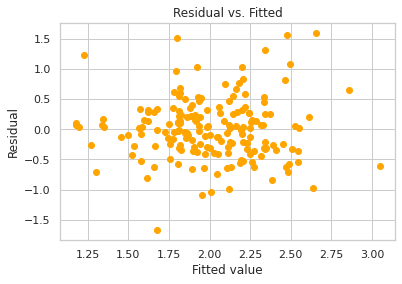

<Figure size 432x288 with 0 Axes>

In [99]:
plt.scatter(model_12.fittedvalues, model_12.resid, color="orange")
# adding title and labels
plt.xlabel('Fitted value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted')
plt.show()
plt.savefig("residuals")

In [100]:
Y = lambeth_lsoa["Crime_Rate_Winter"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_13=sm.OLS(Y,X).fit()

model_13.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Crime_Rate_Winter   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     7.298
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           1.55e-09
Time:                        16:38:27   Log-Likelihood:                -348.31
No. Observations:                 178   AIC:                             718.6
Df Residuals:                     167   BIC:                             753.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                        -11.8385      3.138     -3.772      0.000     -18.034      -5.643
light_density                                               1471.5172    755.387      1.948      0.053     -19.822    2962.857
Index of Multiple Deprivation (IMD) Score                      0.1190      0.037      3.199      0.002       0.046       0.193
Lone parent household (%)                                     -0.1662      0.058     -2.870      0.005      -0.281      -0.052
BAME (%)                                                       0.0826      0.026      3.173      0.002       0.031       0.134
Social rented (%)                                              0.0489      0.019      2.640      0.009       0.012       0.085
Private rented (%)                                             0.0882      0.024      3.640      0.000       0.040       0.136
Highest level of qualification: Level 2 qualifications (%)     0.1271      0.123      1.033      0.303      -0.116       0.370
Unemployment Rate (%)                                         -0.1430      0.111     -1.285      0.201      -0.363       0.077
Median Household Income                                        0.0001   3.68e-05      2.905      0.004    3.42e-05       0.000
English not first language (%)                                 0.0365      0.038      0.964      0.337      -0.038       0.111
==============================================================================
Omnibus:                      146.365   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2217.099
Skew:                           2.948   Prob(JB):                         0.00
Kurtosis:                      19.253   Cond. No.                     2.11e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
Y = lambeth_lsoa["Crime_Rate_Winter"]
X = lambeth_lsoa[["lightcount",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_14=sm.OLS(Y,X).fit()

model_14.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Crime_Rate_Winter   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     17.98
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           2.50e-14
Time:                        16:38:27   Log-Likelihood:                -343.15
No. Observations:                 178   AIC:                             698.3
Df Residuals:                     172   BIC:                             717.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -2.9626      1.097     -2.701      0.008      -5.128      -0.797
lightcount                                                     0.0214      0.003      6.328      0.000       0.015       0.028
Index of Multiple Deprivation (IMD) Score                      0.1159      0.021      5.625      0.000       0.075       0.157
Private rented (%)                                             0.0363      0.017      2.162      0.032       0.003       0.069
Highest level of qualification: Level 2 qualifications (%)    -0.1962      0.075     -2.599      0.010      -0.345      -0.047
English not first language (%)                                 0.0686      0.028      2.432      0.016       0.013       0.124
==============================================================================
Omnibus:                      139.373   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1655.332
Skew:                           2.857   Prob(JB):                         0.00
Kurtosis:                      16.804   Cond. No.                         833.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
Y = lambeth_lsoa["Crime_Rate_Log_Winter"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_15=sm.OLS(Y,X).fit()

model_15.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Crime_Rate_Log_Winter   R-squared:                       0.345
Model:                               OLS   Adj. R-squared:                  0.306
Method:                    Least Squares   F-statistic:                     8.810
Date:                   Wed, 02 Feb 2022   Prob (F-statistic):           1.54e-11
Time:                           16:38:27   Log-Likelihood:                -78.712
No. Observations:                    178   AIC:                             179.4
Df Residuals:                        167   BIC:                             214.4
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -1.4744      0.690     -2.137      0.034      -2.837      -0.112
light_density                                                 65.7619    166.109      0.396      0.693    -262.182     393.705
Index of Multiple Deprivation (IMD) Score                      0.0258      0.008      3.155      0.002       0.010       0.042
Lone parent household (%)                                     -0.0302      0.013     -2.372      0.019      -0.055      -0.005
BAME (%)                                                       0.0134      0.006      2.335      0.021       0.002       0.025
Social rented (%)                                              0.0116      0.004      2.835      0.005       0.004       0.020
Private rented (%)                                             0.0235      0.005      4.406      0.000       0.013       0.034
Highest level of qualification: Level 2 qualifications (%)     0.0118      0.027      0.438      0.662      -0.042       0.065
Unemployment Rate (%)                                         -0.0315      0.024     -1.288      0.199      -0.080       0.017
Median Household Income                                     1.389e-05   8.09e-06      1.717      0.088   -2.08e-06    2.99e-05
English not first language (%)                                 0.0070      0.008      0.844      0.400      -0.009       0.023
==============================================================================
Omnibus:                       15.123   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.295
Skew:                           0.499   Prob(JB):                     1.44e-05
Kurtosis:                       4.418   Cond. No.                     2.11e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [103]:
Y = lambeth_lsoa["Crime_Rate_Log_Winter"]
X = lambeth_lsoa[["lightcount",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_16=sm.OLS(Y,X).fit()

model_16.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Crime_Rate_Log_Winter   R-squared:                       0.374
Model:                               OLS   Adj. R-squared:                  0.356
Method:                    Least Squares   F-statistic:                     20.53
Date:                   Wed, 02 Feb 2022   Prob (F-statistic):           4.74e-16
Time:                           16:38:28   Log-Likelihood:                -74.759
No. Observations:                    178   AIC:                             161.5
Df Residuals:                        172   BIC:                             180.6
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -0.3254      0.243     -1.340      0.182      -0.805       0.154
lightcount                                                     0.0038      0.001      5.024      0.000       0.002       0.005
Index of Multiple Deprivation (IMD) Score                      0.0309      0.005      6.765      0.000       0.022       0.040
Private rented (%)                                             0.0122      0.004      3.276      0.001       0.005       0.019
Highest level of qualification: Level 2 qualifications (%)    -0.0460      0.017     -2.754      0.007      -0.079      -0.013
English not first language (%)                                 0.0161      0.006      2.576      0.011       0.004       0.028
==============================================================================
Omnibus:                       19.986   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.510
Skew:                           0.696   Prob(JB):                     1.75e-06
Kurtosis:                       4.279   Cond. No.                         833.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
Y = lambeth_lsoa["Crime_Rate_Summer"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_17=sm.OLS(Y,X).fit()

model_17.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Crime_Rate_Summer   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     7.704
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           4.40e-10
Time:                        16:38:29   Log-Likelihood:                -355.71
No. Observations:                 178   AIC:                             733.4
Df Residuals:                     167   BIC:                             768.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                        -13.6702      3.272     -4.179      0.000     -20.129      -7.211
light_density                                               1421.0476    787.450      1.805      0.073    -133.592    2975.687
Index of Multiple Deprivation (IMD) Score                      0.1253      0.039      3.230      0.001       0.049       0.202
Lone parent household (%)                                     -0.1472      0.060     -2.438      0.016      -0.266      -0.028
BAME (%)                                                       0.1171      0.027      4.315      0.000       0.064       0.171
Social rented (%)                                              0.0501      0.019      2.592      0.010       0.012       0.088
Private rented (%)                                             0.0962      0.025      3.811      0.000       0.046       0.146
Highest level of qualification: Level 2 qualifications (%)     0.0877      0.128      0.684      0.495      -0.165       0.341
Unemployment Rate (%)                                         -0.1811      0.116     -1.561      0.120      -0.410       0.048
Median Household Income                                        0.0001   3.83e-05      3.513      0.001     5.9e-05       0.000
English not first language (%)                                 0.0261      0.040      0.661      0.510      -0.052       0.104
==============================================================================
Omnibus:                      123.538   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1354.988
Skew:                           2.431   Prob(JB):                    5.86e-295
Kurtosis:                      15.612   Cond. No.                     2.11e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
Y = lambeth_lsoa["Crime_Rate_Summer"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_18=sm.OLS(Y,X).fit()

model_18.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Crime_Rate_Summer   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     7.804
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           1.21e-06
Time:                        16:38:29   Log-Likelihood:                -371.27
No. Observations:                 178   AIC:                             754.5
Df Residuals:                     172   BIC:                             773.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -1.4840      1.378     -1.077      0.283      -4.204       1.237
light_density                                               1144.0189    835.578      1.369      0.173    -505.288    2793.326
Index of Multiple Deprivation (IMD) Score                      0.0984      0.024      4.138      0.000       0.051       0.145
Private rented (%)                                             0.0506      0.019      2.605      0.010       0.012       0.089
Highest level of qualification: Level 2 qualifications (%)    -0.1544      0.090     -1.707      0.090      -0.333       0.024
English not first language (%)                                 0.0480      0.033      1.465      0.145      -0.017       0.113
==============================================================================
Omnibus:                      170.270   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3329.056
Skew:                           3.590   Prob(JB):                         0.00
Kurtosis:                      22.933   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [106]:
Y = lambeth_lsoa["Crime_Rate_Log_Summer"]
X = lambeth_lsoa[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 'Lone parent household (%)',
 'BAME (%)', 
 'Social rented (%)',
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 'Unemployment Rate (%)',
 'Median Household Income',
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_19=sm.OLS(Y,X).fit()

model_19.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Crime_Rate_Log_Summer   R-squared:                       0.320
Model:                               OLS   Adj. R-squared:                  0.279
Method:                    Least Squares   F-statistic:                     7.845
Date:                   Wed, 02 Feb 2022   Prob (F-statistic):           2.86e-10
Time:                           16:38:29   Log-Likelihood:                -77.960
No. Observations:                    178   AIC:                             177.9
Df Residuals:                        167   BIC:                             212.9
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -1.3878      0.687     -2.019      0.045      -2.744      -0.031
light_density                                                 82.0163    165.409      0.496      0.621    -244.546     408.578
Index of Multiple Deprivation (IMD) Score                      0.0291      0.008      3.573      0.000       0.013       0.045
Lone parent household (%)                                     -0.0281      0.013     -2.215      0.028      -0.053      -0.003
BAME (%)                                                       0.0180      0.006      3.164      0.002       0.007       0.029
Social rented (%)                                              0.0085      0.004      2.102      0.037       0.001       0.017
Private rented (%)                                             0.0202      0.005      3.812      0.000       0.010       0.031
Highest level of qualification: Level 2 qualifications (%)     0.0049      0.027      0.180      0.857      -0.048       0.058
Unemployment Rate (%)                                         -0.0279      0.024     -1.145      0.254      -0.076       0.020
Median Household Income                                     1.567e-05   8.05e-06      1.946      0.053   -2.27e-07    3.16e-05
English not first language (%)                                 0.0027      0.008      0.321      0.748      -0.014       0.019
==============================================================================
Omnibus:                        4.526   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.743
Skew:                           0.217   Prob(JB):                       0.0934
Kurtosis:                       3.671   Cond. No.                     2.11e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [107]:
Y = lambeth_lsoa["Crime_Rate_Log_Summer"]
X = lambeth_lsoa[["lightcount",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_20=sm.OLS(Y,X).fit()

model_20.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Crime_Rate_Log_Summer   R-squared:                       0.389
Model:                               OLS   Adj. R-squared:                  0.371
Method:                    Least Squares   F-statistic:                     21.92
Date:                   Wed, 02 Feb 2022   Prob (F-statistic):           5.95e-17
Time:                           16:38:29   Log-Likelihood:                -68.364
No. Observations:                    178   AIC:                             148.7
Df Residuals:                        172   BIC:                             167.8
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -0.2382      0.234     -1.017      0.311      -0.701       0.224
lightcount                                                     0.0045      0.001      6.222      0.000       0.003       0.006
Index of Multiple Deprivation (IMD) Score                      0.0326      0.004      7.406      0.000       0.024       0.041
Private rented (%)                                             0.0098      0.004      2.736      0.007       0.003       0.017
Highest level of qualification: Level 2 qualifications (%)    -0.0375      0.016     -2.328      0.021      -0.069      -0.006
English not first language (%)                                 0.0137      0.006      2.273      0.024       0.002       0.026
==============================================================================
Omnibus:                       11.453   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.769
Skew:                           0.581   Prob(JB):                      0.00278
Kurtosis:                       3.487   Cond. No.                         833.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
Y = lambeth_lsoa["Crime_Rate_Log"]
X = lambeth_lsoa[["light_density"]]
                     
X=sm.add_constant(X)

model_21=sm.OLS(Y,X).fit()

model_21.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Crime_Rate_Log   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.111
Date:                Wed, 02 Feb 2022   Prob (F-statistic):              0.293
Time:                        16:38:29   Log-Likelihood:                -160.51
No. Observations:                 178   AIC:                             325.0
Df Residuals:                     176   BIC:                             331.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.8710      0.133     14.099      0.000       1.609       2.133
light_density   249.1130    236.303      1.054      0.293    -217.239     715.465
==============================================================================
Omnibus:                       15.620   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.085
Skew:                           0.513   Prob(JB):                     9.71e-06
Kurtosis:                       4.435   Cond. No.                     5.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [109]:
Y = lambeth_lsoa["Crime_Rate_Log"]
X = lambeth_lsoa[["lightcount"]]
                     
X=sm.add_constant(X)

model_22=sm.OLS(Y,X).fit()

model_22.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Crime_Rate_Log   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     15.21
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           0.000137
Time:                        16:38:29   Log-Likelihood:                -153.69
No. Observations:                 178   AIC:                             311.4
Df Residuals:                     176   BIC:                             317.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6792      0.094     17.956      0.000       1.495       1.864
lightcount     0.0041      0.001      3.900      0.000       0.002       0.006
==============================================================================
Omnibus:                        6.017   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                6.354
Skew:                           0.299   Prob(JB):                       0.0417
Kurtosis:                       3.706   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
Y = lambeth_lsoa["Crime_Rate_Summer_Log"]
X = lambeth_lsoa[["light_density"]]
                     
X=sm.add_constant(X)

model_23=sm.OLS(Y,X).fit()

model_23.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Crime_Rate_Summer_Log   R-squared:                       0.002
Model:                               OLS   Adj. R-squared:                 -0.003
Method:                    Least Squares   F-statistic:                    0.4095
Date:                   Wed, 02 Feb 2022   Prob (F-statistic):              0.523
Time:                           16:38:30   Log-Likelihood:                -112.03
No. Observations:                    178   AIC:                             228.1
Df Residuals:                        176   BIC:                             234.4
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0018      0.101      9.913      0.000       0.802       1.201
light_density   115.1546    179.960      0.640      0.523    -240.002     470.312
==============================================================================
Omnibus:                       31.392   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.711
Skew:                           0.903   Prob(JB):                     3.58e-12
Kurtosis:                       4.961   Cond. No.                     5.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [111]:
Y = lambeth_lsoa["Crime_Rate_Summer_Log"]
X = lambeth_lsoa[["lightcount"]]
                     
X=sm.add_constant(X)

model_24=sm.OLS(Y,X).fit()

model_24.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Crime_Rate_Summer_Log   R-squared:                       0.084
Model:                               OLS   Adj. R-squared:                  0.079
Method:                    Least Squares   F-statistic:                     16.11
Date:                   Wed, 02 Feb 2022   Prob (F-statistic):           8.83e-05
Time:                           16:38:30   Log-Likelihood:                -104.44
No. Observations:                    178   AIC:                             212.9
Df Residuals:                        176   BIC:                             219.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8103      0.071     11.427      0.000       0.670       0.950
lightcount     0.0032      0.001      4.014      0.000       0.002       0.005
==============================================================================
Omnibus:                       12.895   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.729
Skew:                           0.599   Prob(JB):                      0.00104
Kurtosis:                       3.646   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
Y = lambeth_lsoa["Crime_Rate_Winter_Log"]
X = lambeth_lsoa[["light_density"]]
                     
X=sm.add_constant(X)

model_25=sm.OLS(Y,X).fit()

model_25.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Crime_Rate_Winter_Log   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                 -0.002
Method:                    Least Squares   F-statistic:                    0.6649
Date:                   Wed, 02 Feb 2022   Prob (F-statistic):              0.416
Time:                           16:38:30   Log-Likelihood:                -116.08
No. Observations:                    178   AIC:                             236.2
Df Residuals:                        176   BIC:                             242.5
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8123      0.103      7.857      0.000       0.608       1.016
light_density   150.1262    184.109      0.815      0.416    -213.219     513.472
==============================================================================
Omnibus:                       47.341   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.103
Skew:                           1.245   Prob(JB):                     3.68e-21
Kurtosis:                       5.548   Cond. No.                     5.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [113]:
Y = lambeth_lsoa["Crime_Rate_Winter_Log"]
X = lambeth_lsoa[["lightcount"]]
                     
X=sm.add_constant(X)

model_26=sm.OLS(Y,X).fit()

model_26.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Crime_Rate_Winter_Log   R-squared:                       0.063
Model:                               OLS   Adj. R-squared:                  0.058
Method:                    Least Squares   F-statistic:                     11.86
Date:                   Wed, 02 Feb 2022   Prob (F-statistic):           0.000716
Time:                           16:38:30   Log-Likelihood:                -110.61
No. Observations:                    178   AIC:                             225.2
Df Residuals:                        176   BIC:                             231.6
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6675      0.073      9.092      0.000       0.523       0.812
lightcount     0.0029      0.001      3.444      0.001       0.001       0.005
==============================================================================
Omnibus:                       30.681   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.955
Skew:                           0.960   Prob(JB):                     1.73e-10
Kurtosis:                       4.541   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
lambeth_lsoa_nonan = lambeth_lsoa[lambeth_lsoa["ASB_Count"].notna()]

In [115]:
lambeth_lsoa_nonan.isnull().values.any()

True

In [116]:
Y = lambeth_lsoa_nonan["ASB_Crime_Rate_Log"]
X = lambeth_lsoa_nonan[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_27=sm.OLS(Y,X).fit(missing='drop')

model_27.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ASB_Crime_Rate_Log   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     10.24
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           1.35e-08
Time:                        16:38:30   Log-Likelihood:                -108.04
No. Observations:                 177   AIC:                             228.1
Df Residuals:                     171   BIC:                             247.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.5059      0.316      1.602      0.111      -0.118       1.129
light_density                                                 87.6071    192.121      0.456      0.649    -291.627     466.841
Index of Multiple Deprivation (IMD) Score                      0.0274      0.005      5.038      0.000       0.017       0.038
Private rented (%)                                             0.0112      0.004      2.521      0.013       0.002       0.020
Highest level of qualification: Level 2 qualifications (%)    -0.0503      0.021     -2.434      0.016      -0.091      -0.010
English not first language (%)                                 0.0155      0.008      2.063      0.041       0.001       0.030
==============================================================================
Omnibus:                        8.964   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.962
Skew:                           0.481   Prob(JB):                       0.0113
Kurtosis:                       3.538   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [117]:
lambeth_lsoa_nonan = lambeth_lsoa[lambeth_lsoa["ASB_Count_Winter"].notna()]

In [118]:
Y = lambeth_lsoa_nonan["ASB_Crime_Rate_Winter_Log"]
X = lambeth_lsoa_nonan[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_27=sm.OLS(Y,X).fit(missing='drop')

model_27.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     ASB_Crime_Rate_Winter_Log   R-squared:                       0.181
Model:                                   OLS   Adj. R-squared:                  0.157
Method:                        Least Squares   F-statistic:                     7.512
Date:                       Wed, 02 Feb 2022   Prob (F-statistic):           2.14e-06
Time:                               16:38:30   Log-Likelihood:                -24.165
No. Observations:                        176   AIC:                             60.33
Df Residuals:                            170   BIC:                             79.35
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.1995      0.197      1.013      0.313      -0.189       0.588
light_density                                                 26.9108    120.156      0.224      0.823    -210.278     264.100
Index of Multiple Deprivation (IMD) Score                      0.0133      0.003      3.917      0.000       0.007       0.020
Private rented (%)                                             0.0048      0.003      1.713      0.088      -0.001       0.010
Highest level of qualification: Level 2 qualifications (%)    -0.0377      0.013     -2.913      0.004      -0.063      -0.012
English not first language (%)                                 0.0099      0.005      2.094      0.038       0.001       0.019
==============================================================================
Omnibus:                       35.541   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.049
Skew:                           1.042   Prob(JB):                     2.48e-13
Kurtosis:                       4.891   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [119]:
lambeth_lsoa_nonan = lambeth_lsoa[lambeth_lsoa["ASB_Count_Summer"].notna()]

In [120]:
Y = lambeth_lsoa_nonan["ASB_Crime_Rate_Summer_Log"]
X = lambeth_lsoa_nonan[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_27=sm.OLS(Y,X).fit(missing='drop')

model_27.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     ASB_Crime_Rate_Summer_Log   R-squared:                       0.189
Model:                                   OLS   Adj. R-squared:                  0.166
Method:                        Least Squares   F-statistic:                     7.983
Date:                       Wed, 02 Feb 2022   Prob (F-statistic):           8.74e-07
Time:                               16:38:30   Log-Likelihood:                -40.322
No. Observations:                        177   AIC:                             92.64
Df Residuals:                            171   BIC:                             111.7
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.1992      0.215      0.925      0.356      -0.226       0.625
light_density                                                 41.8806    131.046      0.320      0.750    -216.796     300.557
Index of Multiple Deprivation (IMD) Score                      0.0164      0.004      4.424      0.000       0.009       0.024
Private rented (%)                                             0.0050      0.003      1.631      0.105      -0.001       0.011
Highest level of qualification: Level 2 qualifications (%)    -0.0330      0.014     -2.341      0.020      -0.061      -0.005
English not first language (%)                                 0.0116      0.005      2.261      0.025       0.001       0.022
==============================================================================
Omnibus:                       12.986   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.726
Skew:                           0.615   Prob(JB):                      0.00105
Kurtosis:                       3.588   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [121]:
lambeth_lsoa_nonan = lambeth_lsoa[lambeth_lsoa["Public_Order_Count"].notna()]

In [122]:
Y = lambeth_lsoa_nonan["Public_order_Crime_Rate_Log"]
X = lambeth_lsoa_nonan[["light_density",  'Index of Multiple Deprivation (IMD) Score',
 
 'Private rented (%)',
 'Highest level of qualification: Level 2 qualifications (%)',
 
 'English not first language (%)']]
                     
X=sm.add_constant(X)

model_28=sm.OLS(Y,X).fit()

model_28.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Public_order_Crime_Rate_Log   R-squared:                       0.231
Model:                                     OLS   Adj. R-squared:                  0.207
Method:                          Least Squares   F-statistic:                     9.897
Date:                         Wed, 02 Feb 2022   Prob (F-statistic):           2.71e-08
Time:                                 16:38:31   Log-Likelihood:                -27.419
No. Observations:                          171   AIC:                             66.84
Df Residuals:                              165   BIC:                             85.69
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -0.2871      0.205     -1.399      0.164      -0.692       0.118
light_density                                                 78.6163    122.917      0.640      0.523    -164.077     321.310
Index of Multiple Deprivation (IMD) Score                      0.0151      0.004      4.207      0.000       0.008       0.022
Private rented (%)                                             0.0140      0.003      4.886      0.000       0.008       0.020
Highest level of qualification: Level 2 qualifications (%)    -0.0091      0.013     -0.678      0.498      -0.036       0.017
English not first language (%)                                 0.0003      0.005      0.055      0.957      -0.009       0.010
==============================================================================
Omnibus:                       69.922   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              245.737
Skew:                           1.597   Prob(JB):                     4.35e-54
Kurtosis:                       7.928   Cond. No.                     2.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

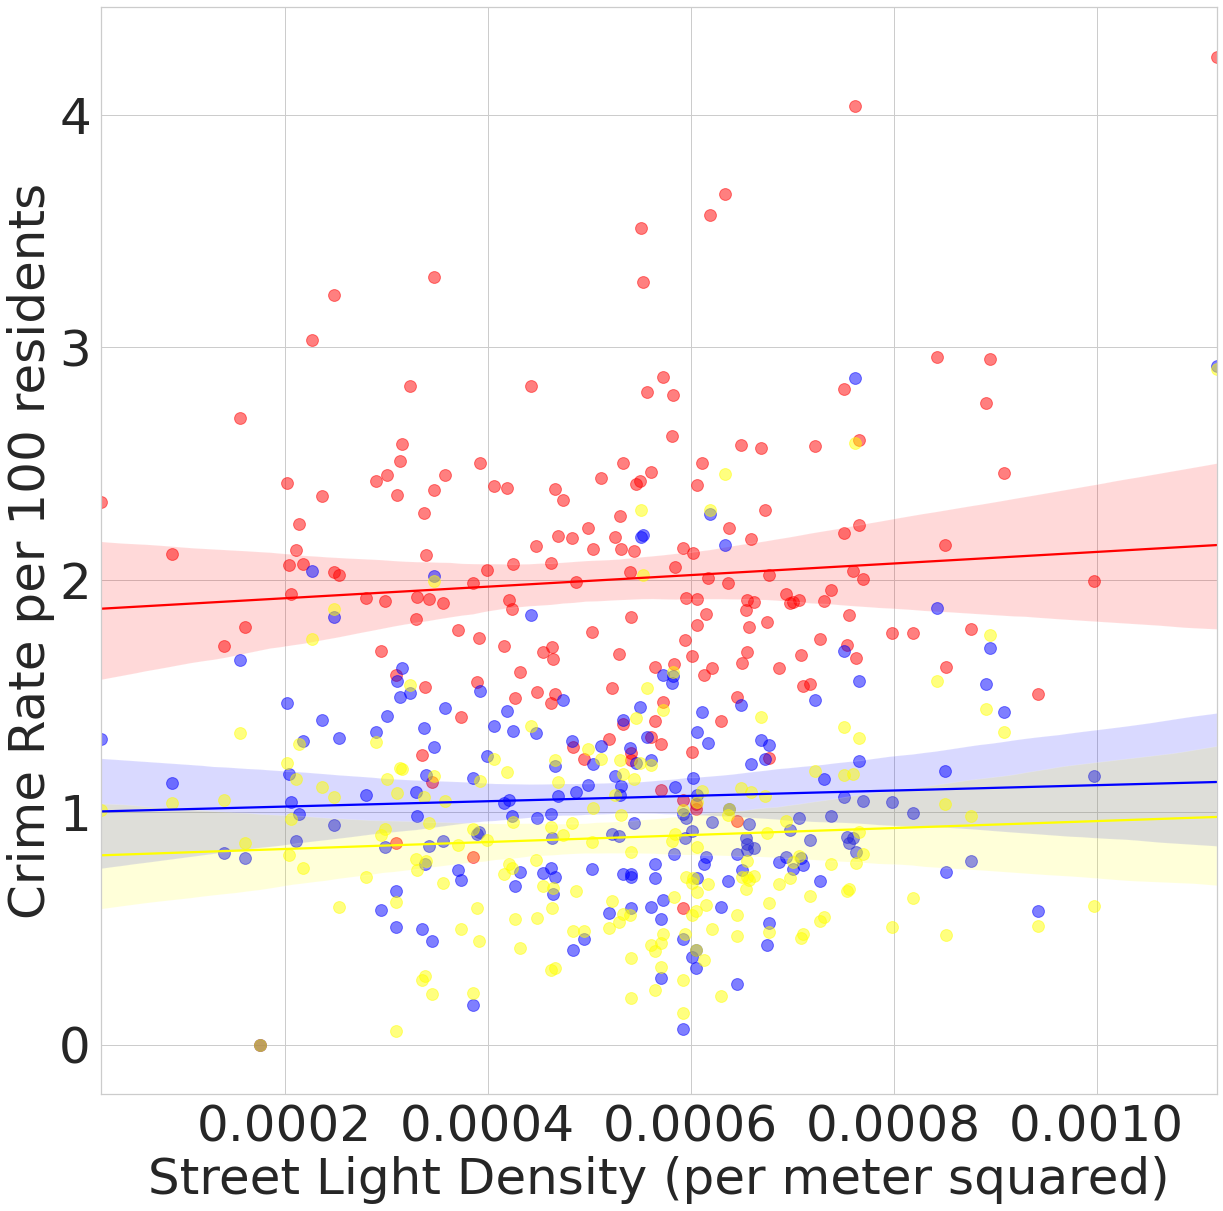

In [123]:
# Plot simple regressions

fig, axs = plt.subplots(1, figsize=(20,20))

sns.regplot(ax=axs, x="light_density", y="Crime_Rate_Log", data=lambeth_lsoa, fit_reg=True, color="red", scatter_kws={'alpha': 0.5, "s":140})
sns.regplot(ax=axs, x="light_density", y="Crime_Rate_Log_Summer", data=lambeth_lsoa, fit_reg=True, color="blue", scatter_kws={'alpha': 0.5, "s":140})
sns.regplot(ax=axs, x="light_density", y="Crime_Rate_Log_Winter", data=lambeth_lsoa, fit_reg=True, color="yellow", scatter_kws={'alpha': 0.5, "s":140})


axs.set_xlabel("Street Light Density (per meter squared)")
axs.set_ylabel("Crime Rate per 100 residents")
axs.xaxis.label.set_size(50)
axs.yaxis.label.set_size(50)
axs.xaxis.set_tick_params(labelsize=50)
axs.yaxis.set_tick_params(labelsize=50)

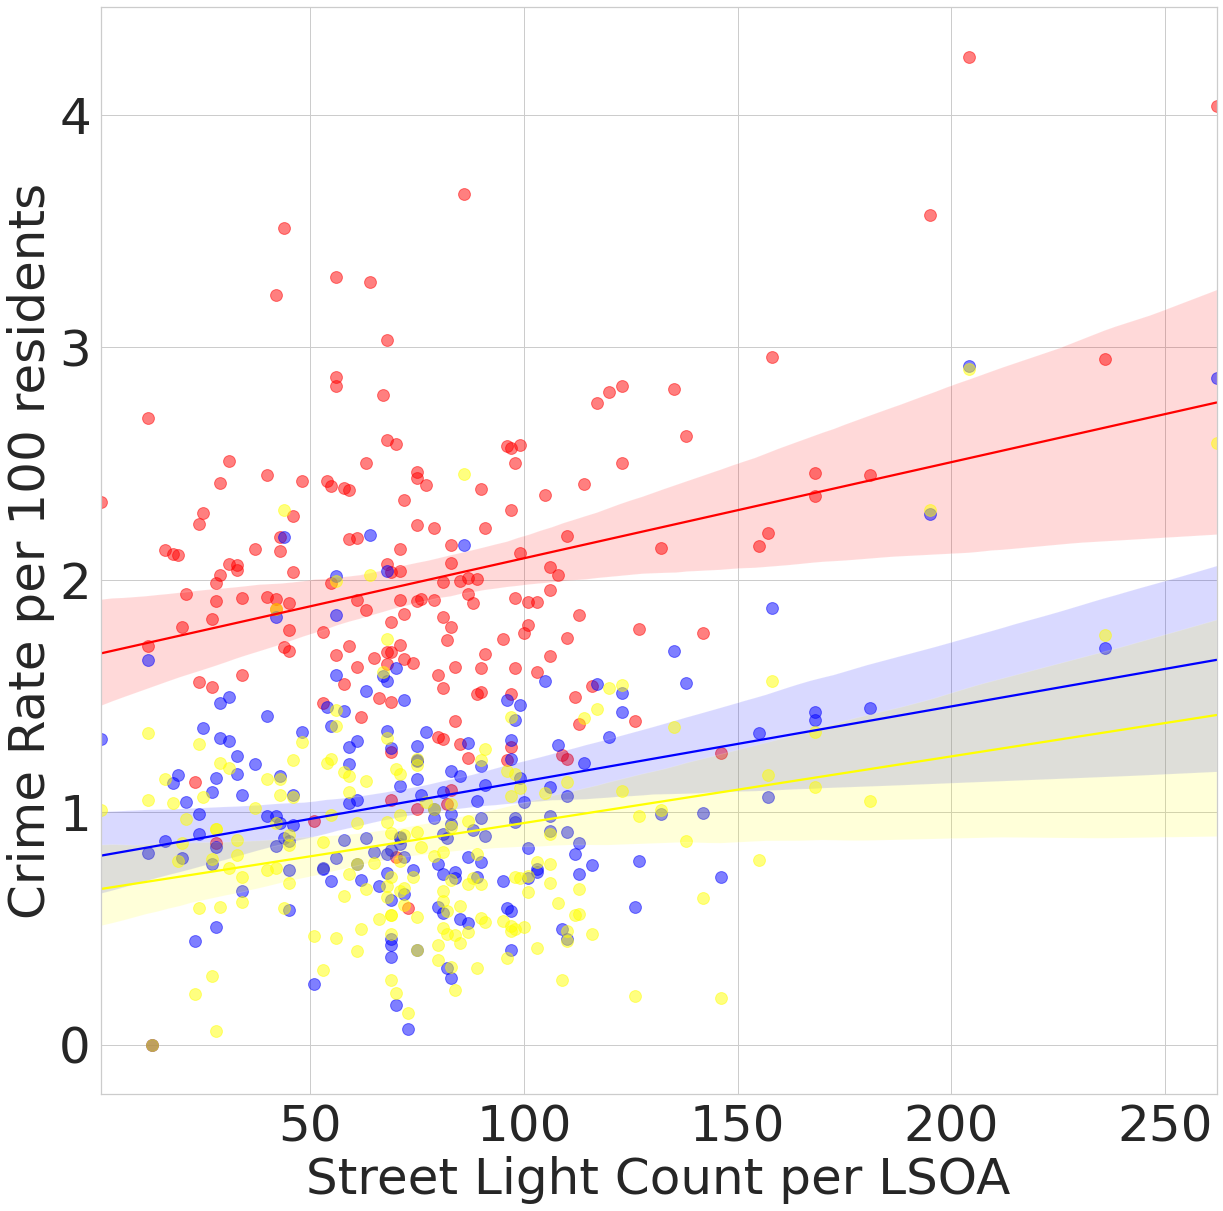

In [124]:
# Plot simple regressions

fig, axs = plt.subplots(1, figsize=(20,20))

sns.regplot(ax=axs, x="lightcount", y="Crime_Rate_Log", data=lambeth_lsoa, fit_reg=True, color="red", scatter_kws={'alpha': 0.5, "s":140})
sns.regplot(ax=axs, x="lightcount", y="Crime_Rate_Log_Summer", data=lambeth_lsoa, fit_reg=True, color="blue", scatter_kws={'alpha': 0.5, "s":140})
sns.regplot(ax=axs, x="lightcount", y="Crime_Rate_Log_Winter", data=lambeth_lsoa, fit_reg=True, color="yellow", scatter_kws={'alpha': 0.5, "s":140})


axs.set_xlabel("Street Light Count per LSOA")
axs.set_ylabel("Crime Rate per 100 residents")
axs.xaxis.label.set_size(50)
axs.yaxis.label.set_size(50)
axs.xaxis.set_tick_params(labelsize=50)
axs.yaxis.set_tick_params(labelsize=50)

# 10. Odds Ratio

In [125]:
# Filter data

street_crimes = ["Anti-social behaviour","Public order","Theft from the person","Violence and sexual offences","Robbery"]
lambeth_crime_gdf_street = lambeth_crime_gdf.loc[lambeth_crime_gdf["Crime type"].isin(street_crimes)]

In [126]:
# Change to northings and eastings 

coord = LL84toEN(lambeth_crime_gdf_street["Longitude"],lambeth_crime_gdf_street["Latitude"])
lambeth_crime_gdf_street["easting"]=coord[0]
lambeth_crime_gdf_street["northing"]=coord[1]

/tmp/ipykernel_2421/837895940.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  vlon36, vlat36 = transform(v84, v36, longitude, latitude)


In [127]:
# Create dataframe 

lambeth_crime_gdf_street_test = gpd.GeoDataFrame(
    lambeth_crime_gdf_street, geometry=gpd.points_from_xy(lambeth_crime_gdf_street.easting, lambeth_crime_gdf_street.northing))

lambeth_crime_gdf_street_test = lambeth_crime_gdf_street_test.set_crs(lambeth_lsoa.crs.to_string())

In [128]:
# Check projections
projection(lambeth_crime_gdf_street_test, lambeth_lsoa)

The projections are the same


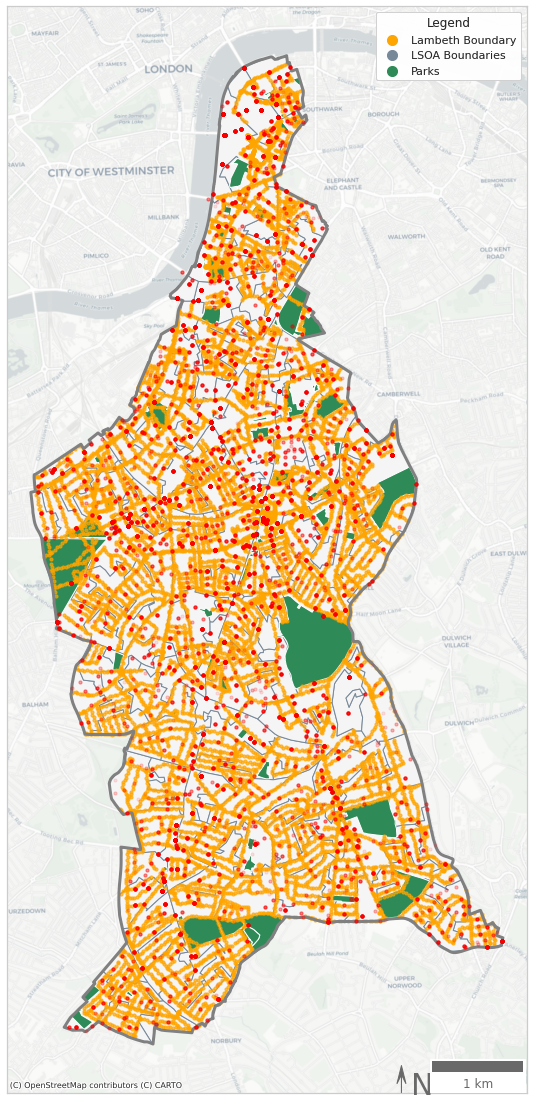

In [129]:
# Create distnace between crime and nearest street light

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
#ax.set_aspect('equal')
#ax.axis('off')
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lambeth_lsoa.plot(ax=ax, edgecolor="lightslategray", facecolor="whitesmoke")

# Plot inner london boundary
lambeth_outline.plot(ax=ax, edgecolor="grey", facecolor="none", linewidth=3, zorder=10)

# Plot parks
parks.plot(ax=ax, facecolor="seagreen")

# Plot crimes
lambeth_crime_gdf_street_test.plot(ax=ax, zorder=40, facecolor="red", markersize=10, alpha=0.1)

# Add basemap
ctx.add_basemap(ax, crs=lsoa.crs.to_string(), source=ctx.providers.CartoDB.Positron)

lights.plot(ax=ax, facecolor="orange",markersize=10, alpha=0.7, edgecolor="orange")

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow
ax.text(x=532700, y=169100,s='N', fontsize=30, color="dimgray")
ax.arrow(532600, 169110, 0,200,length_includes_head=True, head_width=100, head_length=100, overhang=2, zorder=1, color="dimgray")
    
# Add legend

l1 = plt.scatter([],[], s=100, marker='o', color='orange')
l2 = plt.scatter([],[], s=100, marker='o', color='lightslategray')
l3 = plt.scatter([],[], s=100, marker='o', color='seagreen')
  
labels = ["Lambeth Boundary", "LSOA Boundaries", "Parks"]

legend = ax.legend([l1, l2, l3], labels, loc="upper right", title='Legend')
    
ax.add_artist(legend)

# Save figure

plt.savefig(os.path.join("figures","Lambeth_Crime.png"), dpi=300, bbox_inches="tight",transparent=True)

In [130]:
# Save shapefiles for QGIS editing 
winter = ["2019-01","2019-02","2019-12"]
crime_winter = lambeth_crime_gdf_street_test.loc[lambeth_crime_gdf_street_test["Month"].isin(winter)]
crime_winter.to_file("crime_winter_point")

summer = ["2019-06","2019-07","2019-08"] 
crime_summer = lambeth_crime_gdf_street_test.loc[lambeth_crime_gdf_street_test["Month"].isin(summer)]
crime_summer.to_file("crime_summer_point")

lambeth_crime_gdf_street_test.to_file("point.shp")

/tmp/ipykernel_2421/3032691155.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  crime_winter.to_file("crime_winter_point")
/tmp/ipykernel_2421/3032691155.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  crime_summer.to_file("crime_summer_point")
/tmp/ipykernel_2421/3032691155.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lambeth_crime_gdf_street_test.to_file("point.shp")


In [140]:
# Calculate odds ratio for all crime

oddratio("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/OddsRatio/AllBufferCounts10metres.csv", lambeth_crime_gdf_street_test)

Odds Ratio for https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/OddsRatio/AllBufferCounts10metres.csv
OddsR:  0.44470505453266096 p-Value: 0.0
7584 17054
24638
0.30781719295397353
0.6921828070460264


In [146]:
# Calculate odds ratio for all crime

oddratio("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/OddsRatio/WinterBufferCountFinal.csv", crime_winter)

Odds Ratio for https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/OddsRatio/WinterBufferCountFinal.csv
OddsR:  0.422675026123302 p-Value: 2.1237829391678948e-137
1618 3828
5446
0.2970987881013588
0.7029012118986412


In [145]:
# Calculate odds ratio for all crime

oddratio("https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/OddsRatio/SummerBufferCountFinal.csv", crime_summer)

Odds Ratio for https://raw.githubusercontent.com/rubyimogenjohnson/QM_Written_Investigation/main/OddsRatio/SummerBufferCountFinal.csv
OddsR:  0.4501580611169652 p-Value: 1.149264289255011e-150
2136 4745
6881
0.3104199970934457
0.6895800029065543
